# Energy Analytics Data Challenge 

# [using Python (Pandas,  statsmodels), FB prophet]

## Business Use Case: Prediction of Energy Consumption of a Retail Store 

## Description

From the data set provided below, concerning the energy consumption of a retail store in 2014, we build a *timeseries model* to *predict* the **consumed energy (kWh)** made within a **specific time frame**. We provide both a *short-term (60 & 90 calendar days)* and a *long-term forecast (semester & one year prediction)*. The simulated time series of energy consumption which is returned by the model is surprisingly similar with the one provided, except some peaks during the hot summer days and the New Year's Eve. At these times, the forecasted consumption is significantly lower, than the one had during the same periods in 2014. Having historical data of two and more years, would allow us to better incorporate these seasonalities in our model and hopefully provide even better predictions.

In another front, we compare our results with the one returned by the **[FB prophet](https://research.fb.com/prophet-forecasting-at-scale/)** library, as it is was trained over the **Energy Consumption time series (kWh)** alone. We find that this model also provide good results, although shifted towards greater values of forecasted consumed energy than the one had during the same periods in 2014. We believe that having the ability to incorporate the **`'kWh'` ~ `'Temp'` & `'Traffic'`** dependence in this model, would make it much better.

## Dataset

Dataset **`consumption.csv`** contains all signals of a **smart energy meter** that it is plugged in the store, along with information about **weather conditions** of the area and the **traffic of the store**, between dates `'2014-01-01'` and `'2014-12-31'`. 

The file is in comma separated format and contains the following variables:

* **`'signal_id'`:** unique id of every signal of the smart meter
* **`'kW'`:** the consumption that the signal transmits the given moment (have in mind: kWh = kW * h).
* **`'temperature'`:** the external temperature on the given moment in Celsius
* **`'traffic'`:** a category of the amount of traffic in the store the given moment (0: no traffic/closed - 4: peak)
* **`'timestamp'`:** the timestamp of the signal

## 1. Loading Libraries and User-defined Functions

In [1]:
# Required Libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from fbprophet import Prophet

from __future__ import print_function
np.set_printoptions(precision=4, suppress=True)

from matplotlib import pyplot as plt
import matplotlib as mlb
import seaborn as sns

In [2]:
# Matplotlib/Seaborn Parameters
mlb.style.use('seaborn-whitegrid')
sns.set_context('talk')
%matplotlib inline

mlb.rcParams['figure.titleweight'] = 'bold'
mlb.rcParams['axes.labelweight'] = 'bold'
mlb.rcParams['axes.titleweight'] = 'bold'
mlb.rcParams['figure.figsize'] = [10,6]

In [3]:
# User-Defined Functions
def fitted_model_diagnostic_plots(label, fitted_models):
    #for label in label_list:
    model = fitted_models[label]
    
    # PRINT MODEL SUMMARY
    s = 'REGRESSION MODEL: %s' % label
    print(s)
    print('-' * int(len(s)* (1+1/2)))
    print(model.summary2())

    # RETURNS DIAGNOSTIC PLOTS FOR THE MODEL OF INTEREST
    # Enrich the provided "Design Matrix" with the residuals that the model returns
    print('Diagnostic Plots:\n')
    # Diagnostic Plots for the fit
    regplot_and_qqplot(model)
    # Influence Plots in case of 'OLS' Model
    if model.model.__class__.__name__ == 'OLS':
            influence_plots(model)
    
    # RETURNS TIMEPLOT OF RESIDUALS & THEIR STANDARD DEVIATION ON A USER-DEFINED ROLLING WINDOW
    residuals_timeseries(model, rolling_window=5)
    
def regplot_and_qqplot(model):
    # Residuals Plot & QQ-Plot
    fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(10,6))
    # Residuals vs Fitted Values
    sns.regplot(model.fittedvalues, model.resid, data=None,
                lowess=True, line_kws={'color':'red'}, ax=ax1)
    ax1.set_xlabel('Fitted Values')
    ax1.set_ylabel('Residuals')
    # Q-Q Plot and divergence of normality
    probplot = sm.ProbPlot(model.resid, fit=True)
    probplot.qqplot(line='45', ax=ax2)
    ax2.set_xlim(left=probplot.theoretical_quantiles.min(), 
                 right=probplot.theoretical_quantiles.max())
    ax2.set_ylim(bottom=probplot.sample_quantiles.min(), 
                 top=probplot.sample_quantiles.max())
    fig.tight_layout(w_pad=4)
    return fig

def influence_plots(model):    
    # Influence Plots
    fig, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
    # Infulence Plot [Studentized Residuals vs Leverage]
    sm.graphics.influence_plot(model, ax=ax3)
    # Leverage Statistics vs Normalized Residuals Squared
    sm.graphics.plot_leverage_resid2(model, ax=ax4)
    # Finalize the diagnostic plots
    fig.tight_layout(w_pad=4)
    return fig

def residuals_timeseries(model, rolling_window=5):
    fig, (ax5, ax6) = plt.subplots(nrows=2, ncols=1, sharey=True, figsize=(10,12))
    # TimeSeries of Residuals
    model.resid.plot(ax=ax5)
    kwh_resid_ma5 = model.resid.rolling(rolling_window, min_periods=rolling_window).mean()
    kwh_resid_ma5.plot(ax=ax5, style='r--', linewidth=2)
    ax5.legend(['Residuals of AVG kWh', 'MA5'], loc='upper right')
    ax5.set_xlabel('Months in 2014')
    ax5.set_ylabel('kWh')
    ax5.set_title('Residuals of AVG Energy Consumption')
    # TimeSeries of Rolling Standard Deviation of Residuals
    kwh_resid_std5 = model.resid.rolling(rolling_window, min_periods=rolling_window).std()
    kwh_resid_std5.plot(ax=ax6, style='g-')
    ax6.set_xlabel('Months in 2014')
    ax6.set_ylabel('(+/-) kWh')
    ax6.set_title('Standard Deviation of Residuals\n[Rolling Window: 5 Calendar Days]')
    # Finalize the TimeSeries Plots
    fig.tight_layout(h_pad=2)
    return fig


def regression_models_statistics(regr_models):
    from collections import OrderedDict
    
    # Keep the label models and their definition in a OrderedDict() structure
    regr_models_fits = OrderedDict((label, []) for label, _ in regr_models)

    # Fit the models of interests
    for label, model in regr_models:
        if model.__class__.__name__ == 'GLSAR':
            fit = model.iterative_fit()
        else:
            fit = model.fit()
        s = '\nREGRESSION MODEL: %s' % label
        print(s)
        print('-' * int(len(s)* (1+1/2)))
        print(fit.summary2())
        regr_models_fits[label] = fit
    
    # Computes the ANOVA Statistics for each of the models
    anova_table = sm.stats.anova_lm(*regr_models_fits.values())

    try:
        anova_table.insert(0, column='model', value=list(regr_models_fits.keys()))
    except: 1

    s = '\nANOVA RESULTS:'
    print(s)
    print('-' * 80)
    print(anova_table)
    return regr_models_fits

## 2. Loading Consumption Data / Validity Checks

First, we load the consumption data set, **`'consumption.csv'`** from file. Note, that no **`'NA'`** values exists, or any other problems.

In [4]:
consumpt_df = pd.read_csv('./02.consumption.csv',
                          parse_dates=['timestamp'],
                          infer_datetime_format=True)

In [5]:
consumpt_df.head()

,signal_id,timestamp,kw,temperature,traffic
0,1,2014-01-01 00:00:00,17.625,1.0,closed
1,2,2014-01-01 01:00:00,17.675,1.0,closed
2,3,2014-01-01 02:00:00,17.775,0.0,closed
3,4,2014-01-01 03:00:00,17.750,0.0,closed
4,5,2014-01-01 04:00:00,17.750,0.0,closed


In [6]:
consumpt_df.dtypes

signal_id               int64
timestamp      datetime64[ns]
kw                    float64
temperature           float64
traffic                object
dtype: object

In [7]:
consumpt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 5 columns):
signal_id      8760 non-null int64
timestamp      8760 non-null datetime64[ns]
kw             8760 non-null float64
temperature    8760 non-null float64
traffic        8760 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 342.3+ KB


### A. Uniqueness of **`'signal_id'`** & **`'timestamp'`** as a surrogate table key [no duplicated records]

In [8]:
# Check the uniqueness of key in data set
num_unique_values = len(pd.unique(consumpt_df['signal_id']))
num_records = len(consumpt_df['signal_id'])
is_key = (num_unique_values == num_records)
print('Checks the uniqueness of \'signal_id\' [key]: %s' % is_key)

Checks the uniqueness of 'signal_id' [key]: True


In [9]:
# Check the uniqueness of key in data set
num_unique_values = len(pd.unique(consumpt_df['timestamp']))
num_records = len(consumpt_df['timestamp'])
is_key = (num_unique_values == num_records)
print('Checks the uniqueness of \'timestamp\' [key]: %s' % is_key)

Checks the uniqueness of 'timestamp' [key]: True


### B. Validity of **`'timestamp'`**

The **`'timestamp'`** values includes signals from the whole 2014, i.e. from **`'2014-01-01'`** to **`'2014-12-31'`**, as described in the problem task.

In [10]:
consumpt_df['timestamp'].describe()

count                    8760
unique                   8760
top       2014-05-09 19:00:00
freq                        1
first     2014-01-01 00:00:00
last      2014-12-31 23:00:00
Name: timestamp, dtype: object

### C. Categorical attributes [`'traffic'`]

In [11]:
consumpt_df['traffic'].describe()

count       8760
unique         5
top       closed
freq        4432
Name: traffic, dtype: object

In [12]:
pd.value_counts(consumpt_df['traffic'])

closed        4432
high          1514
medium        1511
low            991
super high     312
Name: traffic, dtype: int64

### D. Float attributes [`'kw'`, `'tempreture'`]

In [13]:
consumpt_df['kw'].describe()

count    8760.00000
mean       26.56139
std        24.12035
min         0.00000
25%         8.60000
50%        17.45000
75%        36.25000
max       143.62500
Name: kw, dtype: float64

In [14]:
consumpt_df['temperature'].describe()

count    8760.000000
mean       14.093607
std         6.924538
min        -5.000000
25%         8.000000
50%        14.000000
75%        19.000000
max        34.000000
Name: temperature, dtype: float64

## 3. Timeseries Data Analysis: Recognizing possible models to fit

First, we create a new **DataFrame**, **`'consumpt_ts'`**, to accomodate the **Energy Consumption** made by the **retail store (`'kWh'`)**. Since the provided data set has been sampled every single hour, this new **`'kWh'`** attribute will be equal-valued with the provided **`'kw'`** one. We also change the **`'temperature'` column  name** to something sorter for our convenience.

In [15]:
consumpt_df.head()

,signal_id,timestamp,kw,temperature,traffic
0,1,2014-01-01 00:00:00,17.625,1.0,closed
1,2,2014-01-01 01:00:00,17.675,1.0,closed
2,3,2014-01-01 02:00:00,17.775,0.0,closed
3,4,2014-01-01 03:00:00,17.750,0.0,closed
4,5,2014-01-01 04:00:00,17.750,0.0,closed


In [16]:
# Create a new "consumpt_ts" DataFrame
consumpt_ts = pd.DataFrame(data=consumpt_df[['kw', 'temperature', 'traffic']].values,
                           index=consumpt_df['timestamp'].values,
                           columns = ['kW', 'Temp', 'Traffic'])

consumpt_ts.loc[:,'kW'] = consumpt_ts['kW'].astype('float64')
consumpt_ts.loc[:,'Temp'] = consumpt_ts['Temp'].astype('float64')

consumpt_ts = consumpt_ts.assign(kWh = lambda x: x.kW)

### A. Exploratory Data Analysis

It is important to note, that the recorded **energy consumption** depends on the **traffic in store (`Traffic='closed'/'low'/'medium'/'high'/'super high'`)** and the **external weather conditions (temperature,`Temp`)**, as expected.

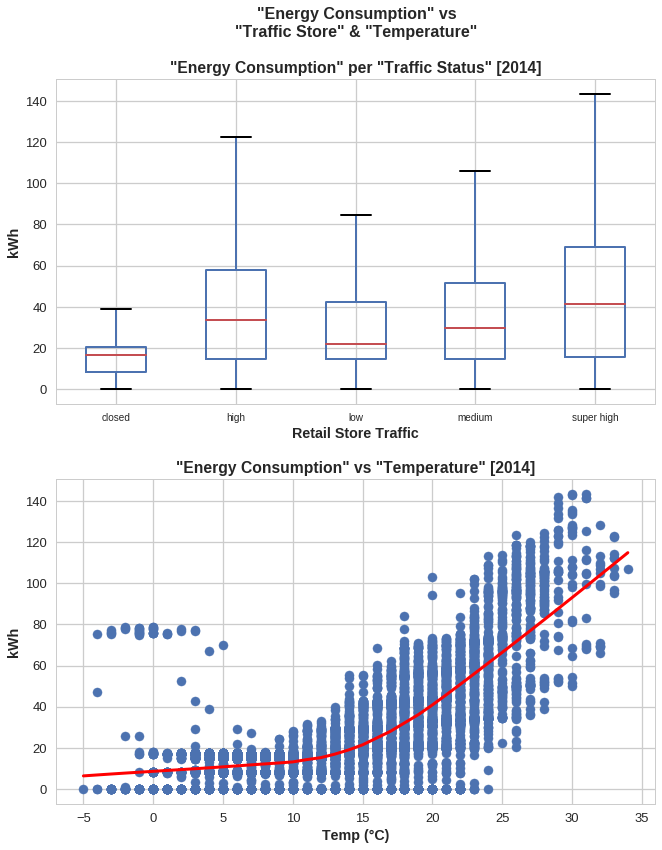

In [17]:
# "kWh" ~ "Temp" & "Traffic" Dependende
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1 , figsize=(10, 12))

# Box-Plot of "kWh" ~ "Traffic"
consumpt_ts.boxplot(column='kWh', by='Traffic', return_type=None, ax=ax1, 
                    boxprops={'linewidth':2}, medianprops={'linewidth':2}, 
                    whiskerprops={'linewidth':2}, capprops={'linewidth':2})
ax1.set_title('\"Energy Consumption\" per \"Traffic Status\" [2014]',
              fontweight='bold')
ax1.set_xlabel('Retail Store Traffic', fontweight='bold')
ax1.set_ylabel('kWh', fontweight='bold')

# Scatterplot of "KWh" ~ "Temp"
ax2.scatter(consumpt_ts['Temp'], consumpt_ts['kWh'])
ys = sm.nonparametric.lowess(consumpt_ts['kWh'].values, consumpt_ts['Temp'].values)
ax2.plot(ys[:,0], ys[:,1], 'r-', linewidth=3)
ax2.set_title('\"Energy Consumption\" vs \"Temperature\" [2014]'
              ,fontweight='bold')
ax2.set_xlabel('Temp (\u00b0C)', fontweight='bold')
ax2.set_ylabel('kWh', fontweight='bold')

# Figure Polishing
fig.tight_layout(h_pad=2, w_pad=2, rect=[0,0,0.93,0.93])
fig.suptitle('\"Energy Consumption\" vs\n\"Traffic Store\" & \"Temperature\"',
             fontsize=16, fontweight='bold')
plt.show()

By resampling the **Energy Consumption Timeseries (`'kWh'`)** on a **Calendar Day Frequence (`'D'`)**, we can have a better understanding of its time evolution and its dependence / correlation with the corresponding **Temperature Timeseries**. The **rolling moving averages** in 5 and in 30 window days, **`MA5`** and **`MA30`**, are also depicted for both series. Note that the standard deviation of the **`'kWh'`** series greatly varies, taking values from `0` to `~750 kWh`, and appears peaks during the hot summer months and the last few days of 2014.

In [18]:
# Resample the Energy Consumption Timeseries on a Calendar Day Frequence ("D")
r = consumpt_ts.resample('D', label='left' ,closed='left')

exclude = 'closed'
def frequent(x, exclude=exclude):
    assert(np.dtype(x) == 'O')
    if len(x)==0 : return -1
    (value, counts) = np.unique(x, return_counts=True)
    if exclude:
        assert(isinstance(exclude, str))
        (value, counts) = value[value != exclude], counts[value != exclude]
    return value[counts.argmax()]

ragg = r.apply({'kW': np.mean,
                'Temp': np.mean,
                'Traffic': frequent,
                'kWh': np.sum})

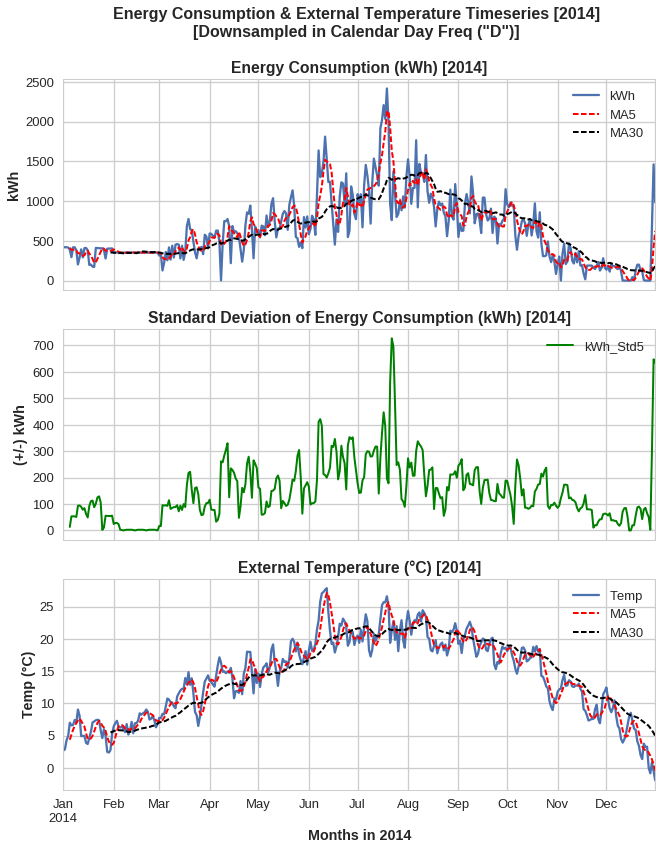

In [19]:
# Rolling Windows:
rollW1 = 5
rollW2 = 30

# TimeSeries Plots of "kWh"/"MA5"/"MA30", "std5(kWh)", "Temp"/"MA5"/"MA30"
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,12))

# Energy Consumption (kWh) [2014]
ragg['kWh'].plot(ax=ax1)
kwh_ma5 = ragg['kWh'].rolling(rollW1, min_periods=rollW1).mean()
kwh_ma5.plot(style='r--', linewidth=2, ax=ax1)
kwh_ma30 = ragg['kWh'].rolling(rollW2, min_periods=rollW2).mean()
kwh_ma30.plot(style='k--', linewidth=2, ax=ax1)
ax1.set_title('Energy Consumption (kWh) [2014]',
              fontweight='bold')
ax1.set_xlabel('Months in 2014', fontweight='bold')
ax1.set_ylabel('kWh', fontweight='bold')
ax1.legend(['kWh', 'MA5', 'MA30'], loc="upper right")

# Standard Deviation of Energy Consumption (kWh) [2014]
kwh_std5 = ragg['kWh'].rolling(rollW1, min_periods=rollW1).std()
kwh_std5.plot(style='g-', linewidth=2, ax=ax2)
ax2.set_title('Standard Deviation of Energy Consumption (kWh) [2014]',
              fontweight='bold')
ax2.set_xlabel('Months in 2014', fontweight='bold')
ax2.set_ylabel('(+/-) kWh', fontweight='bold')
ax2.legend(['kWh_Std5'], loc="upper right")

# External Temperature (Celsius degrees) [2014]
ragg['Temp'].plot(ax=ax3)
temp_ma5 = ragg['Temp'].rolling(rollW1, min_periods=rollW1).mean()
temp_ma5.plot(style='r--', linewidth=2, ax=ax3)
temp_ma30 = ragg['Temp'].rolling(rollW2, min_periods=rollW2).mean()
temp_ma30.plot(style='k--', linewidth=2, ax=ax3)
ax3.set_title(u'External Temperature (\u00b0C) [2014]', fontweight='bold')
ax3.set_xlabel('Months in 2014', fontweight='bold')
ax3.set_ylabel(u'Temp (\u00b0C)', fontweight='bold')
ax3.legend(['Temp', 'MA5', 'MA30'], loc="upper right")

# Figure Polishing
fig.suptitle('Energy Consumption & External Temperature Timeseries [2014]\n[Downsampled in Calendar Day Freq ("D")]',
             fontsize=16, fontweight='bold')
fig.tight_layout(h_pad=2, rect=[0,0,0.93, 0.93])

In the next two diagrams, we also plot the rolling correlation of the **`'kWh'`** and **`'Temp'`** timeseries using a 5 and a 30 Calendar Day window.

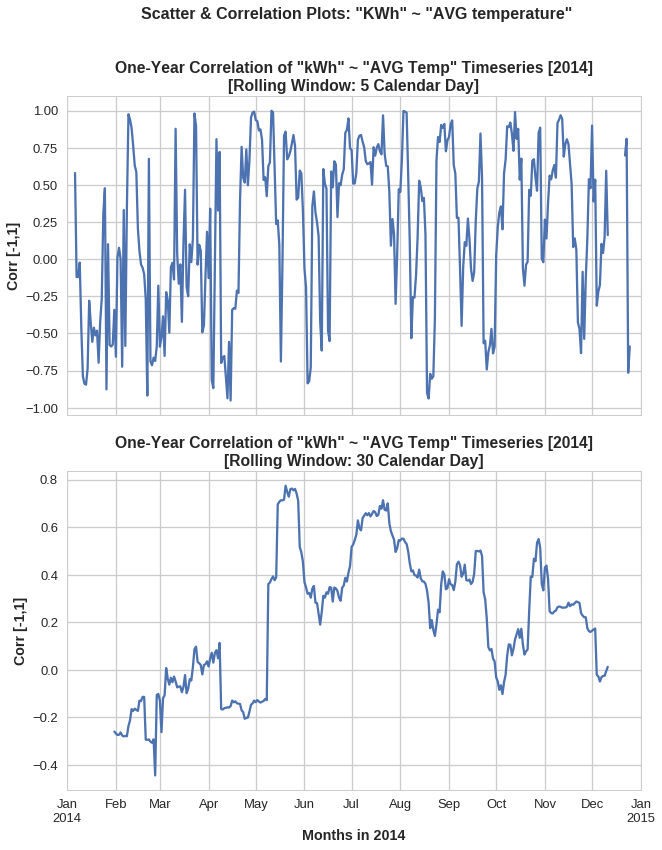

In [20]:
# Rolling Windows
rollW1 = 5
rollW2 = 30

# Rolling Correlation Plots "kWh" ~ "Temp" [Windows: 5 & 30 Business Days]
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,12))

# Rolling Correlation "KWh" ~ "Temp" 
temp_pct_change = ragg['Temp'].pct_change(freq='D')
kwh_pct_change = ragg['kWh'].pct_change(freq='D')

# On Rolling Window: 5 Business Day
kwh_pct_change.rolling(window=rollW1).corr(temp_pct_change).plot(ax=ax1)
ax1.set_title('One-Year Correlation of "kWh" ~ "AVG Temp" Timeseries [2014]\n[Rolling Window: 5 Calendar Day]',
              fontweight='bold')
ax1.set_xlabel('Months in 2014', fontweight='bold')
ax1.set_ylabel('Corr [-1,1]', fontweight='bold')

# On Rolling Window: 30 Business Day
kwh_pct_change.rolling(window=rollW2).corr(temp_pct_change).plot(ax=ax2)
ax2.set_title('One-Year Correlation of "kWh" ~ "AVG Temp" Timeseries [2014]\n[Rolling Window: 30 Calendar Day]',
              fontweight='bold')
ax2.set_xlabel('Months in 2014', fontweight='bold')
ax2.set_ylabel('Corr [-1,1]', fontweight='bold')

# Figure Polishing
fig.suptitle('Scatter & Correlation Plots: "KWh" ~ "AVG temperature"', 
             fontsize=16, fontweight='bold')
fig.tight_layout(h_pad=2, w_pad=2, rect=[0,0,0.93,0.93])

### B. `'kWh'` Timeseries: Univariate analysis and autoregression model adequacy

As a next step, we try to figure out if we can study the **Energy Consumption Timeseries (`'kWh'`)** alone, and if some autorgression model will be adequate enough to provide predictions.

As shown below, there is no easy way to figure out the autoregression model that might fit the data well. The **Energy Consumption Timeseries (`'kWh'`)** appears to have huge variability, especially during the summer months, and there is no easy way to absorb it through a suitable transformation. Even if we detrend the provided timeseries, the obtained results are not great.

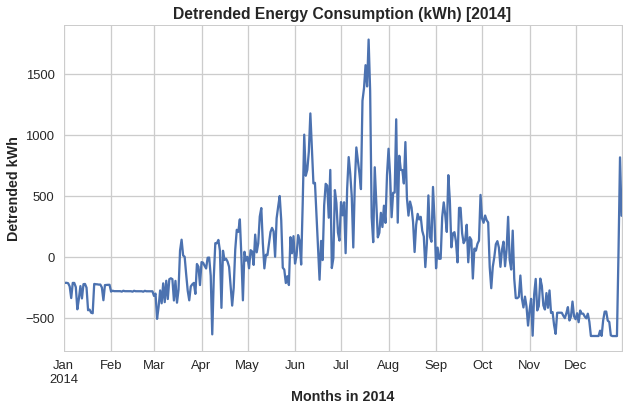

In [21]:
# Detrended Energy Consumption (kWh) [2014]
ydetr = sm.tsa.detrend(ragg['kWh'], order=1)
ydetr = pd.Series(data=ydetr, index=ragg.index)
ydetr.plot(title='Detrended Energy Consumption (kWh) [2014]')
plt.xlabel('Months in 2014')
plt.ylabel('Detrended kWh')
plt.show()

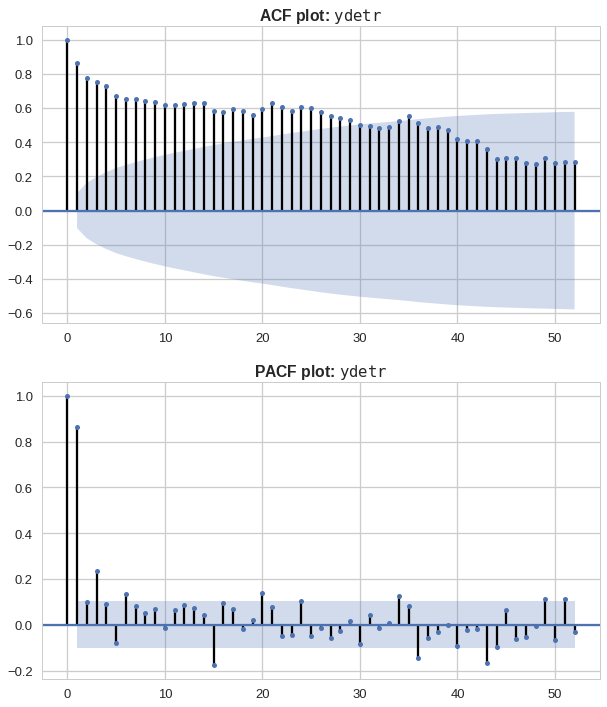

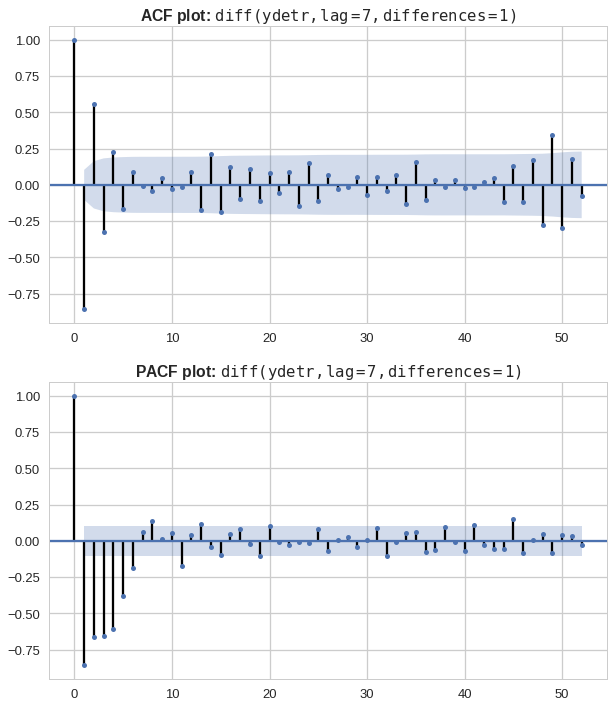

In [22]:
# ACF/PACF Plots over "ydetr"
maxLags = 52
f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,12))
sm.graphics.tsa.plot_acf(ydetr, lags=maxLags, unbiased=True, ax=ax1,
                         title=r'ACF plot: $\tt{ydetr}$') # Suggests diff(x, lag=7, differences=1)
sm.graphics.tsa.plot_pacf(ydetr, lags=maxLags, ax=ax2,
                          title=r'PACF plot: $\tt{ydetr}$')
plt.show()

# diff(x, lag=7, difference=1) 
# [Higher differences are calculated by using `np.diff()` recursively.]
maxLags = 52
f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,12))
sm.graphics.tsa.plot_acf(np.diff(ydetr, n=7), 
                         lags=maxLags, unbiased=True, ax=ax1,
                         title=r'ACF plot: $\tt{diff(ydetr, lag=7, differences=1)}$')
sm.graphics.tsa.plot_pacf(np.diff(ydetr, n=7), lags=maxLags, ax=ax2,
                          title=r'PACF plot: $\tt{diff(ydetr, lag=7, differences=1)}$')
plt.show()

## 4. Model Fitting: utilizing the `'kWh'` ~ `'Temp'` & `'Traffic'` dependence

As stated in the part 3 of this analysis, the correlation between the **`'kWh'`** and **`'Temp'`** timeseries is apparent, whereas a quadratic dependence of **"kWh"** from the corresponding **"Temp" values** seems appropriate to consider. In addition, the **energy consumption** obviously depends on the **traffic status** of the store, but probably not strongly.

In order to incorporate these dependences in our model, we are going to fit a regression model with autocorrelated errors. To do so we will follow an algorithm which has been introduced by Cochrane and Orcutt (1949), and it is described in the ["Time Series Analysis and Its Applications: With R Examples" (Springer Texts in Statistics), by R. H. Shumway and D. S. Stoffer](http://www.springer.com/us/book/9783319524511). However, we are going to use Python here.

More specificaly, assuming the regression model below:

$$
y_{t} = \mathbf{\beta}\mathbf{z_{t}} + x_{t}
$$

where $\mathbf{\beta}$ is an $r\times 1$ vector of regression parameters, $\mathbf{z_{t}}$ an $r\times 1$ vector of regressors (exogeneous variables), and $x_{t}$ a process with some covariance function $\gamma(s,t)$ we will:

1. Run an ordinary regression fit of $y_{t}$ **(`'KWh'`)** on $x_{t}$ **(`'Temp'`)** (acting as if the errors are uncorrelated), and retain the residuals.

2. Fit an ARMA Model to the residuals $\widehat{x_{t}}=y_{t}-\widehat{\mathbf{\beta}}\mathbf{z_{t}}$, say
$$
\widehat{\phi}(B)\widehat{x_{t}} = \widehat{\theta}(B)w_{t}
$$

3. Apply the ARMA transformation to both sides of the initial model in order to obtain the transformed regression one, that is
$$
u_{t} = \frac{\widehat{\phi}(B)}{\widehat{\theta}(B)}y_{t}\quad\text{and}\quad \mathbf{v_{t}}=\frac{\widehat{\phi}(B)}{\widehat{\theta}(B)}\mathbf{z_{t}}
$$

4. Run an ordinary least squares regression assuming uncorrelated errors on the transformed regression model
$$
u_{t} = \mathbf{\beta}\mathbf{v_{t}} + w_{t}\,,
$$

where $w_{t}$ is expected now to be... white noise!

### Choose the best Odinary Regression Model to fit:

In [23]:
# Endogeneous Variable
endog = ragg['kWh'].values

# Exogeneous Design Matrix
max_order = 3
rtemp_demean = sm.tsa.detrend(ragg['Temp'], order=1)
exog_rtemp = np.vander(rtemp_demean, N=max_order+1)

ragg1 = pd.concat([ragg[['kWh', 'Traffic']],
                   pd.DataFrame(exog_rtemp, 
                                index=ragg.index, 
                                columns=['rtemp_demeanCb', 'rtemp_demeanSq', 'rtemp_demean', 'intercept'])],
                  axis=1)

In [24]:
# Keep the label models and their definition in a separate list
# OLS models excluding "Traffic" categorical variable:
regr_models = [('fit1', smf.ols('kWh ~ rtemp_demean', ragg1)),
               ('fitSq1', smf.ols('kWh ~ rtemp_demean + rtemp_demeanSq', ragg1)),
               ('fitCb1', smf.ols('kWh ~ rtemp_demean + rtemp_demeanSq + rtemp_demeanCb', ragg1))]

In [25]:
regr_models_fits = regression_models_statistics(regr_models)


REGRESSION MODEL: fit1
----------------------------------
                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.651    
Dependent Variable: kWh              AIC:                5066.3502
Date:               2017-03-15 16:57 BIC:                5074.1500
No. Observations:   365              Log-Likelihood:     -2531.2  
Df Model:           1                F-statistic:        679.9    
Df Residuals:       363              Prob (F-statistic): 3.36e-85 
R-squared:          0.652            Scale:              62135.   
------------------------------------------------------------------
                 Coef.   Std.Err.    t    P>|t|   [0.025   0.975] 
------------------------------------------------------------------
Intercept       637.4734  13.0474 48.8584 0.0000 611.8154 663.1313
rtemp_demean     54.6592   2.0962 26.0749 0.0000  50.5369  58.7815
------------------------------------------------------------------
Omnibus:             

/usr/local/miniconda/envs/python3-env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/miniconda/envs/python3-env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/miniconda/envs/python3-env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Among the three regression models we fit previously, only the **`fitSq1`** can be further considered, or improved. The more simpler one **`fit1`** has lower **`R-squared`** and **`Adj.R-squared`** statistics, whereas the one that assume a cubic order of dependence for the **`rtemp_demean`** series returns a low **`F`** value with relative large **`p-value`**, `~0.1449`. It also appears a large **condition number**, `~1000`, a fact that might indicate stong multicollinearity or other numerical problems.

It is important to note though, that the categorical variable which keeps the retail store traffic, **`'Traffic'`**, influences the daily energy consumption, a fact that we better take in account.

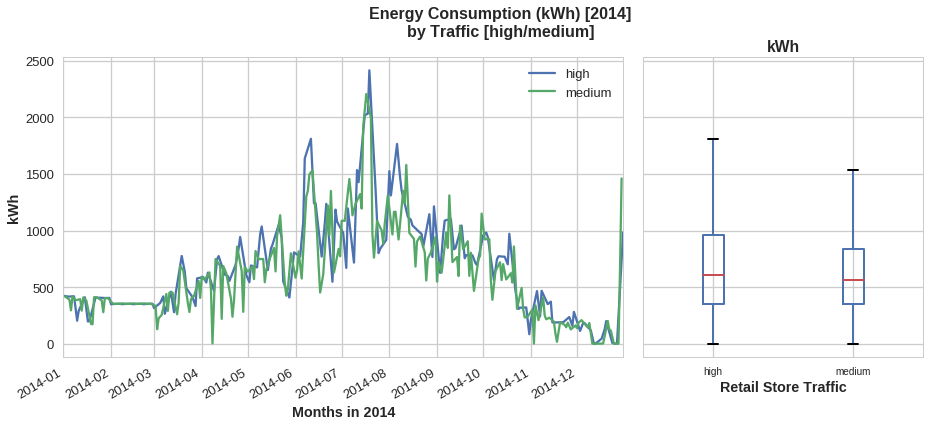

In [26]:
# Energy Consumption (kWh) by "Traffic" (high/medium) [2014]
# Matplotlib Subplots of Different Sizes
fig, (ax1, ax2) =plt.subplots(nrows=1, ncols=2, sharey=True, 
                              gridspec_kw={'width_ratios':[2/3,1/3]}, figsize=(14,6))

# Energy Consumption TimeSeries (kWh) by "Traffic"
factor_groups = ragg1.groupby(by='Traffic')
for value, group in factor_groups:
    group['kWh'].plot(ax=ax1)
ax1.set_xlabel('Months in 2014')
ax1.set_ylabel('kWh')
ax1.legend(np.unique(ragg1['Traffic']), loc='upper right')

# Energy Consumption BoxPlot (kWh) by "Traffic"
ragg1.boxplot(column='kWh', by='Traffic', ax=ax2, 
              boxprops={'linewidth':2}, medianprops={'linewidth':2}, 
              whiskerprops={'linewidth':2}, capprops={'linewidth':2})
ax2.set_xlabel('Retail Store Traffic')

# Figure Polishing
fig.suptitle('Energy Consumption (kWh) [2014]\nby Traffic [high/medium]', 
             fontsize=16, fontweight='bold')
fig.tight_layout(h_pad=2, w_pad=2, rect=[0,0,0.93,0.93])

As a next step, we extend the list of regression models with some more, which also take in account the **`'Traffic'`** categorical variable and improve the **`fitSq1`** model. However, we still use the **`OLS` class** to make the fit.

In [27]:
# OLS Models including the "Traffic" variable and Interactions
regr_models.extend([('fit2', smf.ols('kWh ~ rtemp_demean + C(Traffic)', ragg1)),
                    ('fitSq2', smf.ols('kWh ~  rtemp_demean + rtemp_demeanSq + C(Traffic)', ragg1)),
                    ('fitSq2INT1', smf.ols('kWh ~ (rtemp_demean + rtemp_demeanSq) * C(Traffic)', ragg1)),
                    ('fitSq2INT2', smf.ols('kWh ~ (rtemp_demean * C(Traffic)) + rtemp_demeanSq', ragg1))])

In [28]:
regr_models_fits = regression_models_statistics(regr_models)


REGRESSION MODEL: fit1
----------------------------------
                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.651    
Dependent Variable: kWh              AIC:                5066.3502
Date:               2017-03-15 16:57 BIC:                5074.1500
No. Observations:   365              Log-Likelihood:     -2531.2  
Df Model:           1                F-statistic:        679.9    
Df Residuals:       363              Prob (F-statistic): 3.36e-85 
R-squared:          0.652            Scale:              62135.   
------------------------------------------------------------------
                 Coef.   Std.Err.    t    P>|t|   [0.025   0.975] 
------------------------------------------------------------------
Intercept       637.4734  13.0474 48.8584 0.0000 611.8154 663.1313
rtemp_demean     54.6592   2.0962 26.0749 0.0000  50.5369  58.7815
------------------------------------------------------------------
Omnibus:             

/usr/local/miniconda/envs/python3-env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/miniconda/envs/python3-env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/miniconda/envs/python3-env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


From the **ANOVA results** shown above, the **statistics information criteria (`AIC`, `BIC`)**, and the **variance explained** by each of the models, we choose the  **`fitSq2INT2`** model as the one that fits our data best, with the more simpler one, **`fitSq2`**, coming immediately after. Due to the relatively small data size, we have assumed that the **`AIC`** results are more reliable for our problem. An important advantage of the **`fitSq2INT2`** model, is that incorporate nicely the energy consumption dependence on the external temperature and on the traffic in store, i.e.
```
kWh ~ (rtemp_demean * C(Traffic)) + rtemp_demeanSq,
```
explains 79.0% of variance in the provided data, and as we will show below, it provides residuals which can be predicted by an appropriate autoregression model extremely well! The **`fitSq2`** model also provides a good fit, explains 78.4% of variance in the provided data, returns a comparable **`AIC`** with the **`fitSq2INT2`** model, i.e. 4893.4477, but has significantly larger F-statistics than this one. Consequently, it is also a good candidate model to further explore.

### Fit a suitable SARIMA Model: 

#### ACF / PACF Plots and preliminary list of models to fit.

#### A. `fitSq2INT2`

First, we provide some diagnostic plots of the fitted model, **`fitSq2INT2`**.

REGRESSION MODEL: fitSq2INT2
------------------------------------------
                           Results: Ordinary least squares
Model:                     OLS                    Adj. R-squared:           0.790    
Dependent Variable:        kWh                    AIC:                      4884.4527
Date:                      2017-03-15 16:57       BIC:                      4903.9522
No. Observations:          365                    Log-Likelihood:           -2437.2  
Df Model:                  4                      F-statistic:              342.7    
Df Residuals:              360                    Prob (F-statistic):       2.59e-121
R-squared:                 0.792                  Scale:                    37443.   
-------------------------------------------------------------------------------------
                                   Coef.   Std.Err.    t    P>|t|    [0.025   0.975] 
-------------------------------------------------------------------------------------
Intercept

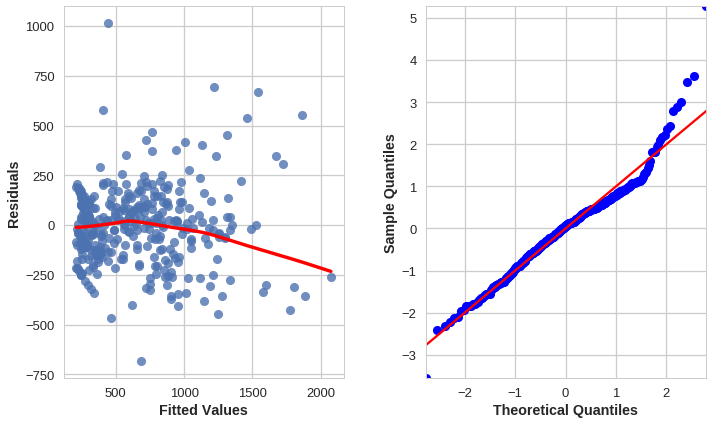

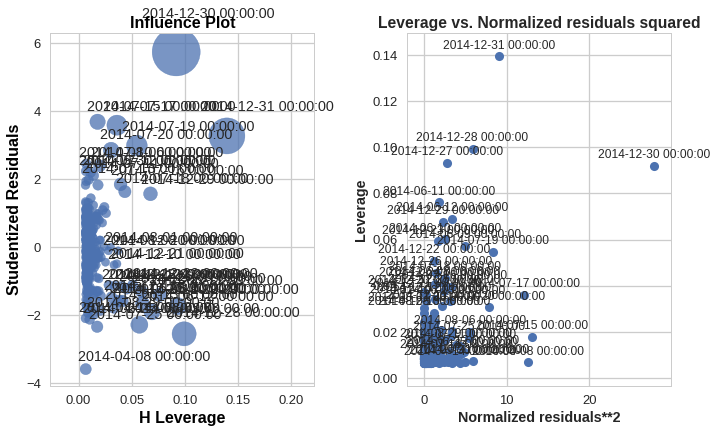

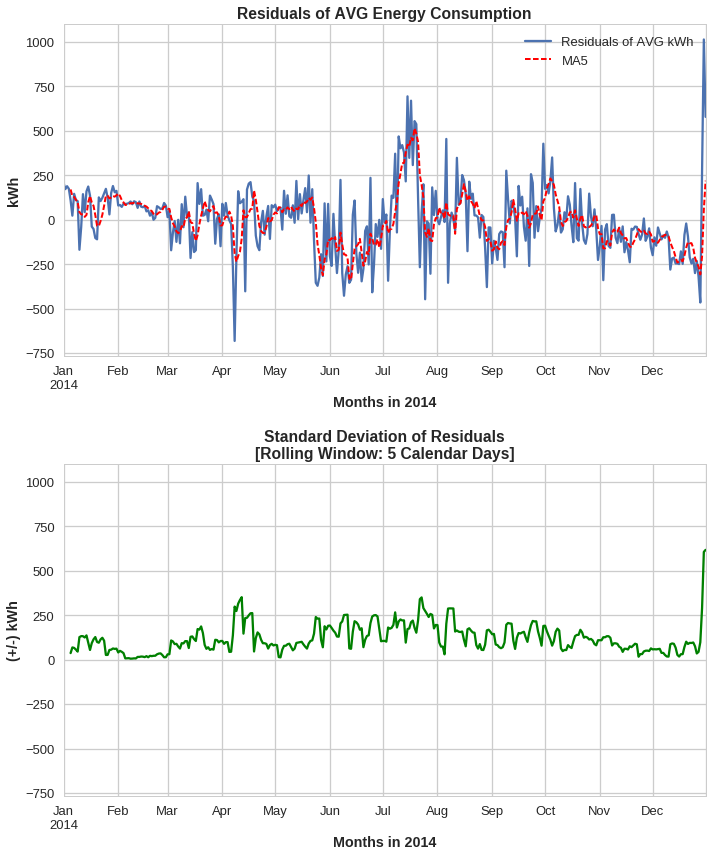

In [29]:
# "fitSq2INT2" Diagnostic Plots
fitted_model_diagnostic_plots('fitSq2INT2', regr_models_fits)

As shown in the diagrams above, the variance of error terms is almost constant and there is no visible pattern in the residuals vs fitted values plot. The normality assumption of the error terms is verified, except some notable divergence at the late dates of the provided timeseries, i.e. during Christmas and the New Year's eve of 2015. The residual timeseries of Energy consumption appears small variability around the zero mean value. However, there are a lot of outliers in the provided data that influence the fitted model significantly.

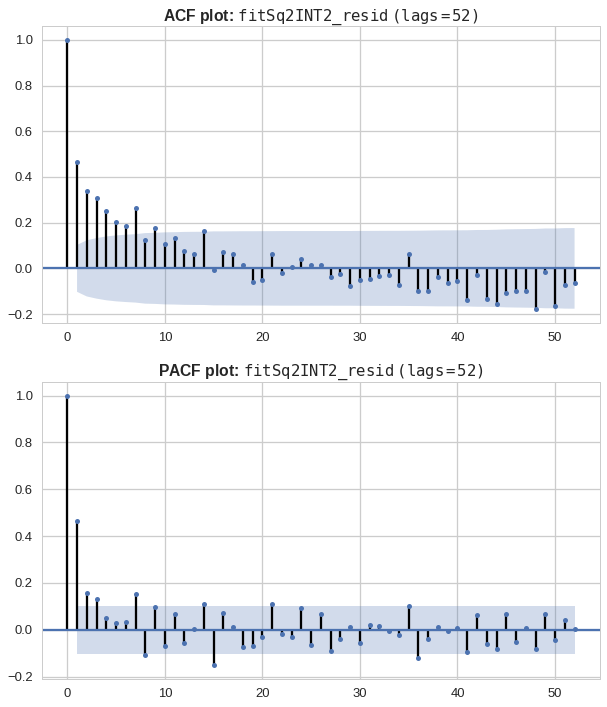

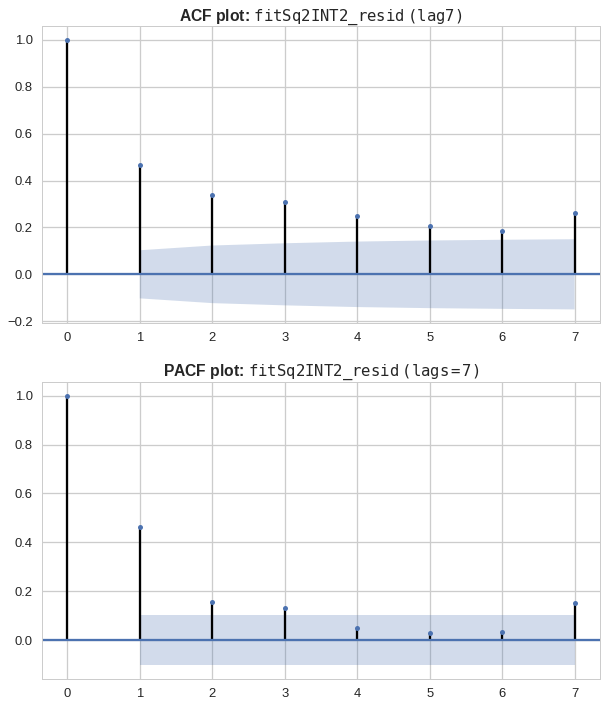

In [30]:
# ACF/PACF Plots over "fitSq2INT2"
label = 'fitSq2INT2'
fitSq2INT2 = regr_models_fits[label]
fitSq2INT2_resid = fitSq2INT2.resid

maxLags = 52
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,12))
fig = sm.graphics.tsa.plot_acf(fitSq2INT2_resid, lags=maxLags, unbiased=True, ax=ax1,
                               title=r'ACF plot: $\tt{fitSq2INT2\_resid\ (lags=52)}$') # Suggests ARMA(?,?) x ARMA(1?,1)_{7}
fig = sm.graphics.tsa.plot_pacf(fitSq2INT2_resid, lags=maxLags, ax=ax2,
                                title=r'PACF plot: $\tt{fitSq2INT2\_resid\ (lags=52)}$')

maxLags = 7
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,12))
fig = sm.graphics.tsa.plot_acf(fitSq2INT2_resid, lags=maxLags, unbiased=True, ax=ax1,
                               title=r'ACF plot: $\tt{fitSq2INT2\_resid\ (lag7)}$') # Suggests ARMA(3,0) x ARMA(1?,1)_{7}
fig = sm.graphics.tsa.plot_pacf(fitSq2INT2_resid, lags=maxLags, ax=ax2,
                                title=r'PACF plot: $\tt{fitSq2INT2\_resid\ (lags=7)}$')

#### ARIMA Models to Investigate/Fit:  

#### $\mathbf{ARIMA(3,0,0)\,\times\,(1,0,1)_{7}}$  and slight variations in the seasonal `AR` and `MA` orders

The previous **ACF/PACF plots** suggest that an  $\mathbf{ARIMA(3,0,0)\,\times\,(1,0,1)_{7}}$ model will provide a really good fit to our data, probably with some variations in the seasonal **AR** and **MA** orders.

In the few lines of code below we examine this fit, the results we obtain from the **`'SARIMAX' stats.tsa` method**, as well as slight variations of this model which are suggested by the t-Statistics of its calculated coefficients. We conclude that indeed the $\mathbf{ARIMA(3,0,0)\,\times\,(1,0,1)_{7}}$ model, **`fitSq2INT2_SARIMAX1`**, fits our data best. Note that the design matrix which was used during the fitting of the **`fitSq2INT2`** model,
```
XReg <- fitSq2INT2.model.data.orig_exog,
```
has been plugged-in as a **matrix of external regressors (exogenous variables)**, in the new **ARIMA fits**.

In [31]:
# SARIMA models over "fitSq2INT2"
s = '\n\'fitSq2INT2\' model:'
print(s)
print('-'*(len(s)+3))
print(fitSq2INT2.summary2())

# Design Matrix
XReg = fitSq2INT2.model.data.orig_exog
# Eendogenous Variable
endog = fitSq2INT2.model.data.orig_endog

# Suggested by the ACF/PACF Plots: 
# [ARIMA(3,0,0 x ARIMA(1,0,1)_{7}] over "fitSq2INT2"
# Instantiate the SARIMAX model of interest
fitSq2INT2_SARIMAX_model1 = sm.tsa.SARIMAX(endog, exog=XReg, 
                                           order=(3,0,0), seasonal_order=(1,0,1,7))
# Fit the model via maximum likelihood
fitSq2INT2_SARIMAX1 = fitSq2INT2_SARIMAX_model1.fit(maxiter=100) # Suggests [ARIMA(2,0,0 x ARIMA(1,0,1)_{7}]
# Provide the summary of results
s = '\n\'fitSq2INT2_SARIMAX1\' model:'
print(s)
print('-'*(len(s)+3))
print(fitSq2INT2_SARIMAX1.summary())

# [ARIMA(2,0,0 x ARIMA(1,0,1)_{7}] over "fitSq2INT2"
# Instantiate the SARIMAX model of interest
fitSq2INT2_SARIMAX_model2 = sm.tsa.SARIMAX(endog, exog=XReg,
                                           order=(2,0,0), seasonal_order=(1,0,1,7))
# Fit the model via maximum likelihood
fitSq2INT2_SARIMAX2 = fitSq2INT2_SARIMAX_model2.fit(maxiter=100)
# Provide the summary of results
s = '\n\'fitSq2INT2_SARIMAX2\' model:'
print(s)
print('-'*(len(s)+3))
print(fitSq2INT2_SARIMAX2.summary())


'fitSq2INT2' model:
-----------------------
                           Results: Ordinary least squares
Model:                     OLS                    Adj. R-squared:           0.790    
Dependent Variable:        kWh                    AIC:                      4884.4527
Date:                      2017-03-15 16:58       BIC:                      4903.9522
No. Observations:          365                    Log-Likelihood:           -2437.2  
Df Model:                  4                      F-statistic:              342.7    
Df Residuals:              360                    Prob (F-statistic):       2.59e-121
R-squared:                 0.792                  Scale:                    37443.   
-------------------------------------------------------------------------------------
                                   Coef.   Std.Err.    t    P>|t|    [0.025   0.975] 
-------------------------------------------------------------------------------------
Intercept                         55

#### Diagnostic Plots: `fitSq2INT2_SARIMAX1` model

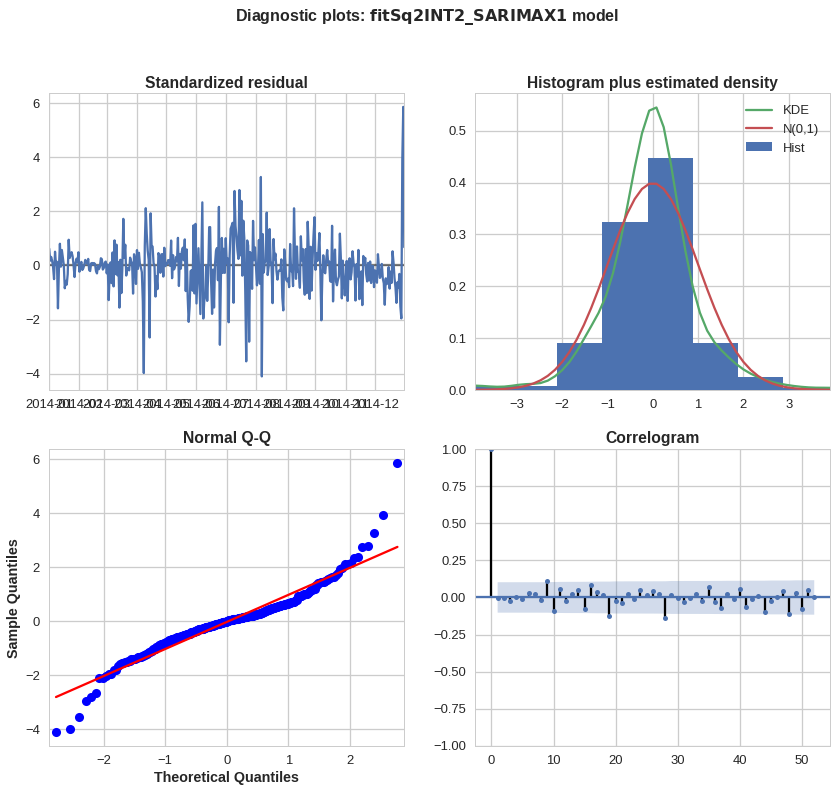

In [32]:
maxLags = 52
fig = plt.figure(figsize=(14,12))
fitSq2INT2_SARIMAX1.plot_diagnostics(lags=maxLags, fig=fig)
fig.suptitle(r'Diagnostic plots: $\mathbf{fitSq2INT2\_SARIMAX1}$ model',
             fontsize=16, fontweight='bold')
plt.show()

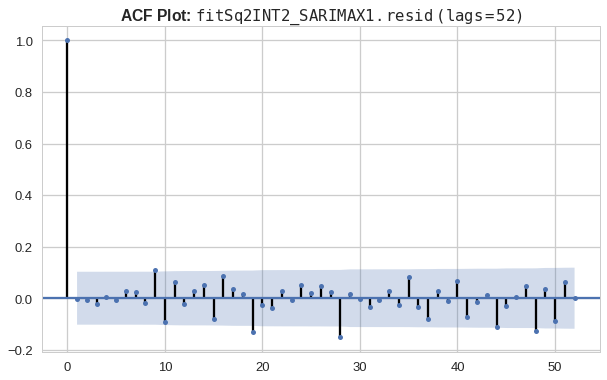

In [33]:
# ACF Plot: fitSq2INT2_SARIMAX1.resid
maxLags=52
sm.graphics.tsa.plot_acf(fitSq2INT2_SARIMAX1.resid, ax=None, lags=maxLags, 
                         unbiased=True, title=r'ACF Plot: $\mathtt{fitSq2INT2\_SARIMAX1.resid\ (lags=52)}$')
plt.show()

#### Diagnostic Plots: `fitSq2INT2_SARIMAX2` model

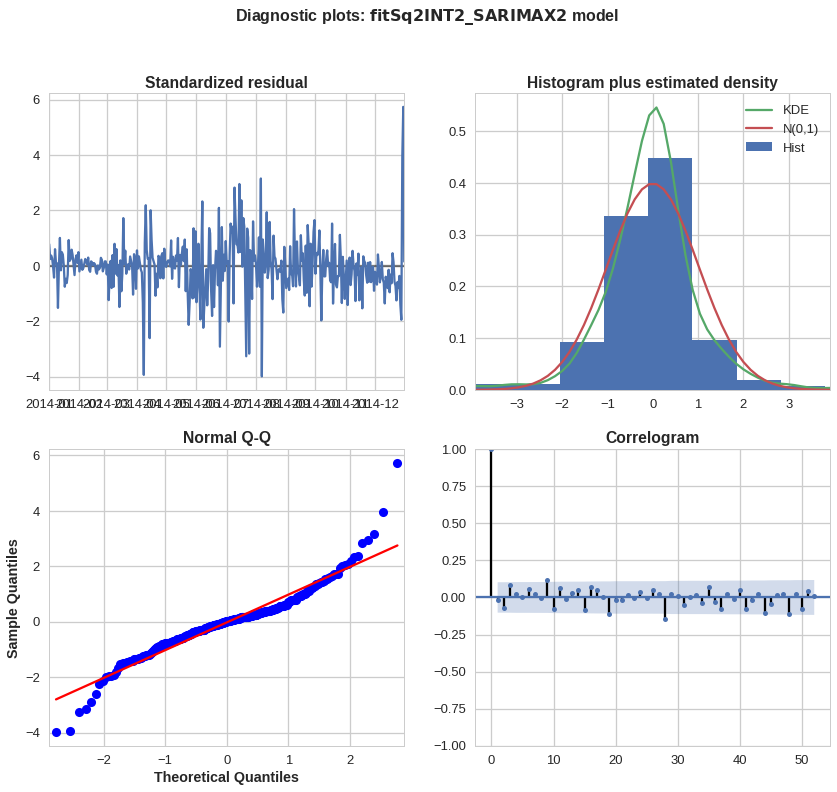

In [34]:
maxLags = 52
fig = plt.figure(figsize=(14,12))
fitSq2INT2_SARIMAX2.plot_diagnostics(lags=maxLags, fig=fig)
fig.suptitle(r'Diagnostic plots: $\mathbf{fitSq2INT2\_SARIMAX2}$ model',
             fontsize=16, fontweight='bold')
plt.show()

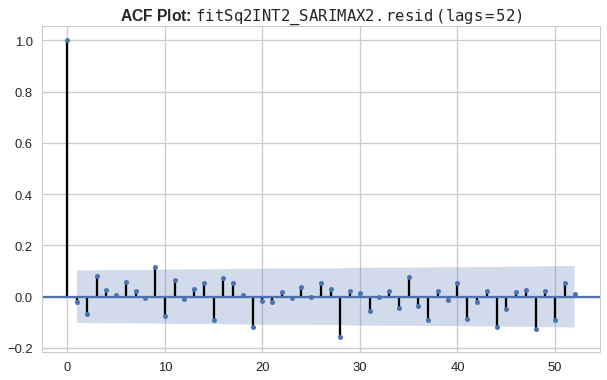

In [35]:
# ACF Plot: fitSq2INT2_SARIMAX2.resid
maxLags=52
sm.graphics.tsa.plot_acf(fitSq2INT2_SARIMAX2.resid, ax=None, lags=maxLags, 
                         unbiased=True, title=r'ACF Plot: $\mathtt{fitSq2INT2\_SARIMAX2.resid\ (lags=52)}$')
plt.show()

From the diagnostic diagrams above, and especially the ones that corresponds to the best of our models, $\mathbf{ARIMA(3,0,0)\,\times\,(1,0,1)_{7}}$ **(`fitSq2INT2_SARIMAX1`)**, we observe that ***outliers exist*** in ***time series***, ***during the hot summer months*** and the ***the last few days of 2014***, but they are not many (Standardized Residuals timeseries plot). The Normal Q-Q plot of Residuals shows ***departure from normality at the
tails*** due to the outliers that occurred primarily during the ***first and last few days of 2014***. Furthermore, the ACF Plot of Residuals does not reveal any autocorrelation.

#### B. `fitSq2`

First, we provide some diagnostic plots of the fitted **`fitSq2`** model.

REGRESSION MODEL: fitSq2
------------------------------------
                    Results: Ordinary least squares
Model:                OLS                Adj. R-squared:       0.784    
Dependent Variable:   kWh                AIC:                  4893.4477
Date:                 2017-03-15 16:58   BIC:                  4909.0472
No. Observations:     365                Log-Likelihood:       -2442.7  
Df Model:             3                  F-statistic:          441.0    
Df Residuals:         361                Prob (F-statistic):   2.55e-120
R-squared:            0.786              Scale:                38481.   
------------------------------------------------------------------------
                      Coef.   Std.Err.    t    P>|t|    [0.025   0.975] 
------------------------------------------------------------------------
Intercept            552.6593  17.8083 31.0338 0.0000  517.6383 587.6803
C(Traffic)[T.medium] -71.1670  20.7397 -3.4314 0.0007 -111.9529 -30.3811
rtemp_deme

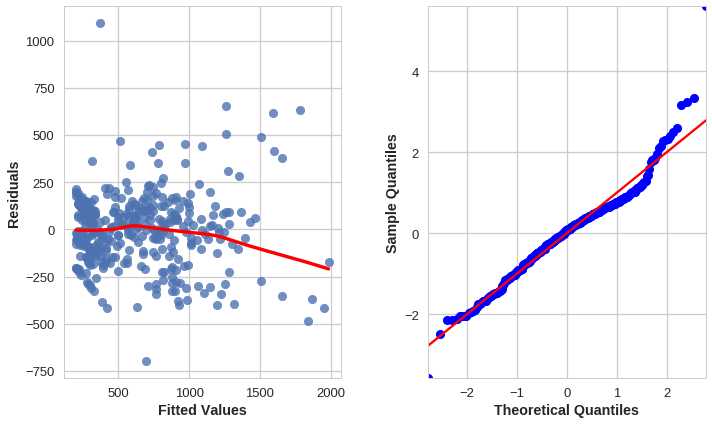

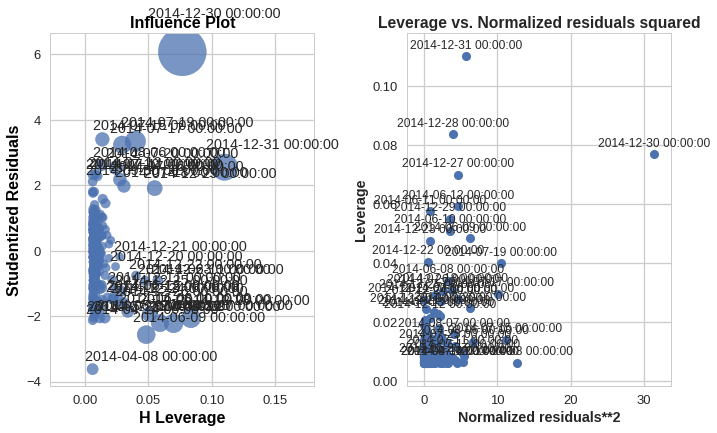

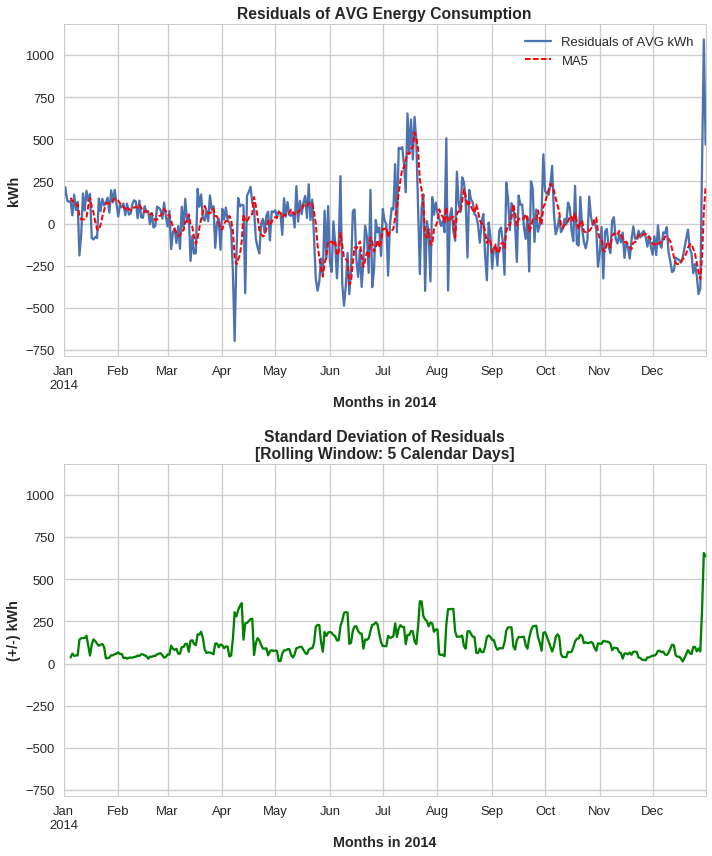

In [36]:
# "fitSq2" Diagnostic Plots
fitted_model_diagnostic_plots('fitSq2', regr_models_fits)

As shown in the diagrams above, the variance of error terms of the **`fitSq2`** model, is almost constant and there is no visible pattern among the residuals and their fitted values. The normality assumption of the error terms is verified, except some notable significant departure at the late dates of the provided timeseries, i.e. during Christmas and the New Year's eve of 2015. The residual timeseries of Energy consumption appears even smaller variability around the zero mean value than the one observed with the **`fitSq2INT2`** model. However, there are again a lot of outliers in the provided data that influence the fitted model significantly.

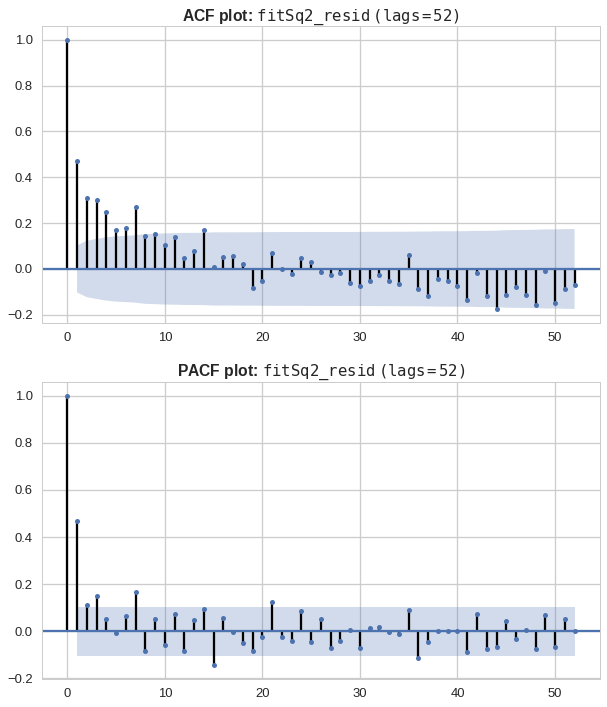

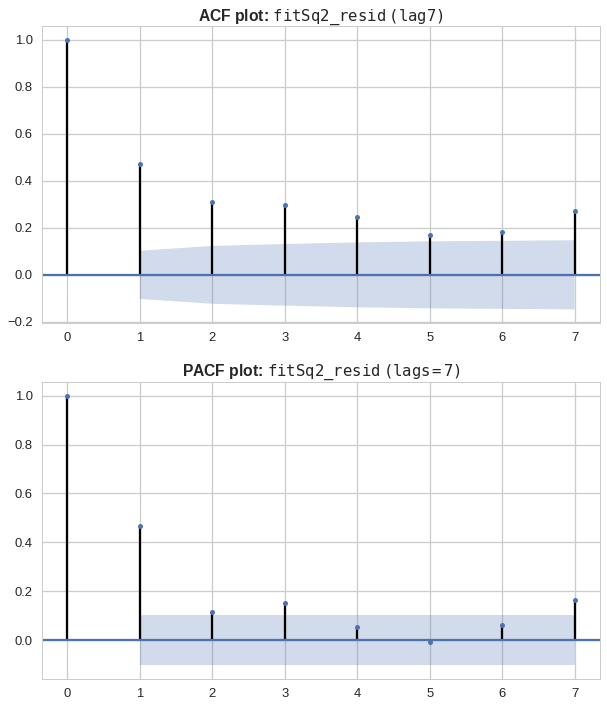

In [37]:
# ACF/PACF Plots: fitSq2.resid
label = 'fitSq2'
fitSq2 = regr_models_fits[label]
fitSq2_resid = fitSq2.resid

maxLags = 52
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,12))
fig = sm.graphics.tsa.plot_acf(fitSq2_resid, lags=maxLags, unbiased=True, ax=ax1,
                               title=r'ACF plot: $\tt{fitSq2\_resid\ (lags=52)}$') # Suggests ARMA(?,?) x ARMA(1,1)_{7}
fig = sm.graphics.tsa.plot_pacf(fitSq2_resid, lags=maxLags, ax=ax2,
                                title=r'PACF plot: $\tt{fitSq2\_resid\ (lags=52)}$')

maxLags = 7
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,12))
fig = sm.graphics.tsa.plot_acf(fitSq2_resid, lags=maxLags, unbiased=True, ax=ax1,
                               title=r'ACF plot: $\tt{fitSq2\_resid\ (lag7)}$') # Suggests ARMA(3?,0) x ARMA(1,1)_{7}
fig = sm.graphics.tsa.plot_pacf(fitSq2_resid, lags=maxLags, ax=ax2,
                                title=r'PACF plot: $\tt{fitSq2\_resid\ (lags=7)}$')

#### ARIMA Models to Investigate/Fit:  

#### $\mathbf{ARIMA(3,0,0)\,\times\,(1,0,1)_{7}}$  and slight variations in the seasonal `AR` and `MA` orders

The previous **ACF/PACF plots** suggest that an  $\mathbf{ARIMA(3,0,0)\,\times\,(1,0,1)_{7}}$ model will provide a really good fit to our data, probably with some variations in the seasonal **AR** and **MA** orders.

In the few lines of code below we examine this fit, the results we obtain from the **`'SARIMAX' stats.tsa` method**, as well as slight variations of this model which are suggested by the t-Statistics of its calculated coefficients. We conclude that indeed the $\mathbf{ARIMA(2,0,0)\,\times\,(1,0,1)_{7}}$ model, **`fitSq2_SARIMAX2`**, fits our data best. Note that the design matrix which was used during the fitting of the **`fitSq2`** model,
```
XReg <- fitSq2.model.data.orig_exog,
```
has been plugged-in as a **matrix of external regressors (exogenous variables)**, in the new **ARIMA fits**.

In [38]:
# [ARIMA(3,0,0 x ARIMA(1?,0,1)_{7}] over "fitSq2"
s = '\n\'fitSq2\' model:'
print(s)
print('-'*(len(s)+3))
print(fitSq2.summary2())

# Design Matrix
XReg = fitSq2.model.data.orig_exog
# Endogenous Variable
endog = fitSq2.model.data.orig_endog

# Suggested by the ACF/PACF Plots: 
# [ARIMA(3,0,0 x ARIMA(1,0,1)_{7}] over "fitSq2"
# Instantiate the SARIMAX model of interest
fitSq2_SARIMAX_model1 = sm.tsa.SARIMAX(endog, exog=XReg, 
                                       order=(3,0,0), seasonal_order=(1,0,1,7))                               
# Fit the model via maximum likelihood
fitSq2_SARIMAX1 = fitSq2_SARIMAX_model1.fit(maxiter=150) # Suggests [ARIMA(2,0,0 x ARIMA(1,0,1)_{7}]
# Provide the summary of results
s = '\n\'fitSq2_SARIMAX1\' model:'
print(s)
print('-'*(len(s)+3))
print(fitSq2_SARIMAX1.summary())

# [ARIMA(2,0,0 x ARIMA(1,0,1)_{7}] over "fitSq2"
# Instantiate the SARIMAX model of interest
fitSq2_SARIMAX_model2 = sm.tsa.SARIMAX(endog, exog=XReg,
                                       order=(2,0,0), seasonal_order=(1,0,1,7))
# Fit the model via maximum likelihood
fitSq2_SARIMAX2 = fitSq2_SARIMAX_model2.fit(maxiter=100)
# Provide the summary of results
s = '\n\'fitSq2_SARIMAX2\' model:'
print(s)
print('-'*(len(s)+3))
print(fitSq2_SARIMAX2.summary())


'fitSq2' model:
-------------------
                    Results: Ordinary least squares
Model:                OLS                Adj. R-squared:       0.784    
Dependent Variable:   kWh                AIC:                  4893.4477
Date:                 2017-03-15 16:59   BIC:                  4909.0472
No. Observations:     365                Log-Likelihood:       -2442.7  
Df Model:             3                  F-statistic:          441.0    
Df Residuals:         361                Prob (F-statistic):   2.55e-120
R-squared:            0.786              Scale:                38481.   
------------------------------------------------------------------------
                      Coef.   Std.Err.    t    P>|t|    [0.025   0.975] 
------------------------------------------------------------------------
Intercept            552.6593  17.8083 31.0338 0.0000  517.6383 587.6803
C(Traffic)[T.medium] -71.1670  20.7397 -3.4314 0.0007 -111.9529 -30.3811
rtemp_demean          60.1042   1.6

#### Diagnostic Plots:  `fitSq2_SARIMAX1` model

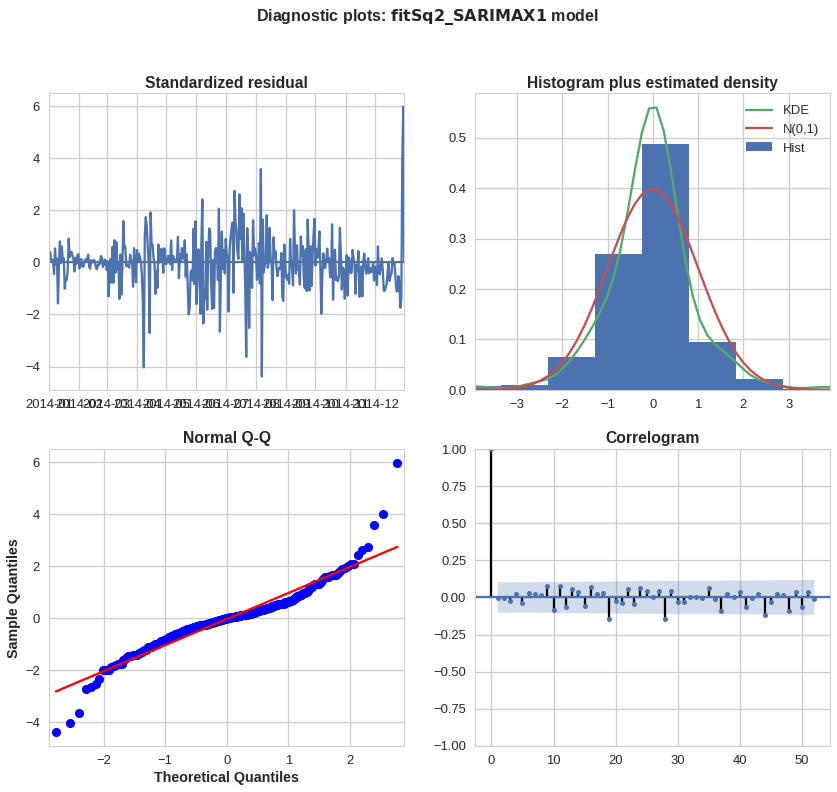

In [39]:
maxLags = 52
fig = plt.figure(figsize=(14,12))
fitSq2_SARIMAX1.plot_diagnostics(lags=maxLags, fig=fig)
fig.suptitle(r'Diagnostic plots: $\mathbf{fitSq2\_SARIMAX1}$ model',
             fontsize=16, fontweight='bold')
plt.show()

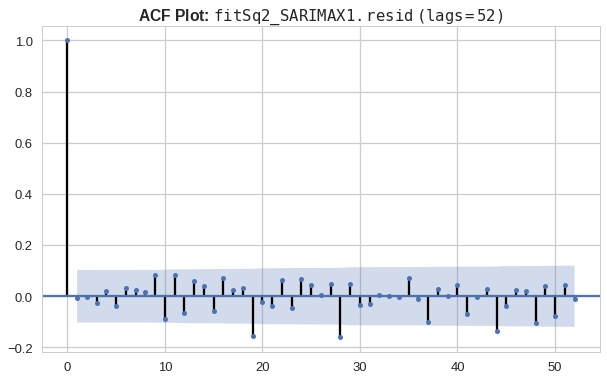

In [40]:
# ACF Plot: fitSq2_SARIMAX1.resid
maxLags=52
sm.graphics.tsa.plot_acf(fitSq2_SARIMAX1.resid, ax=None, lags=maxLags, 
                         unbiased=True, title=r'ACF Plot: $\mathtt{fitSq2\_SARIMAX1.resid\ (lags=52)}$')
plt.show()

#### Diagnostic Plots: `fitSq2_SARIMAX2` model

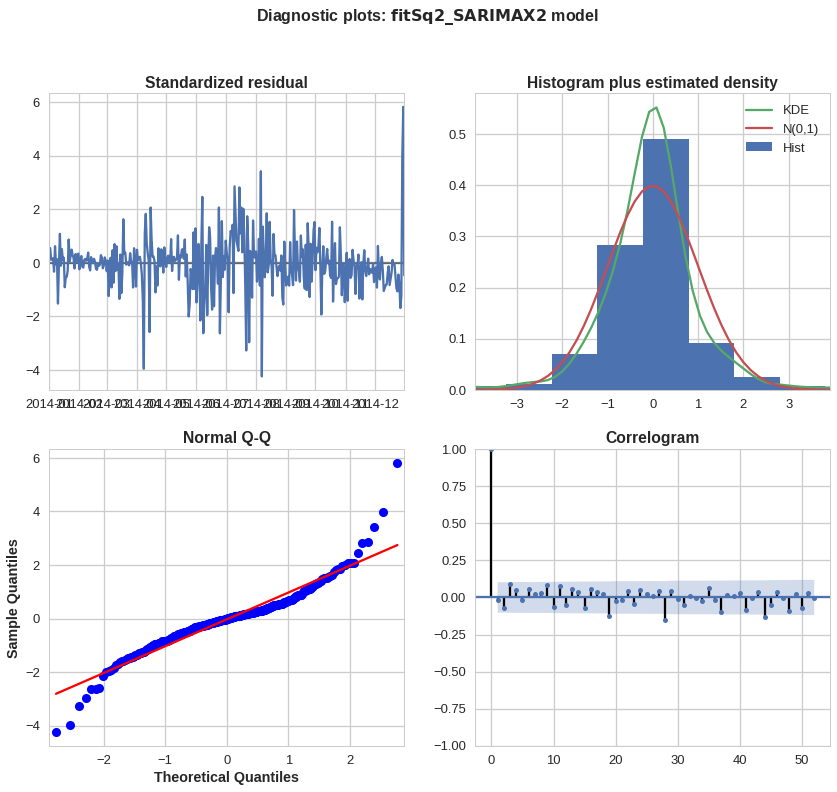

In [41]:
maxLags = 52
fig = plt.figure(figsize=(14,12))
fitSq2_SARIMAX2.plot_diagnostics(lags=maxLags, fig=fig)
fig.suptitle(r'Diagnostic plots: $\mathbf{fitSq2\_SARIMAX2}$ model',
             fontsize=16, fontweight='bold')
plt.show()

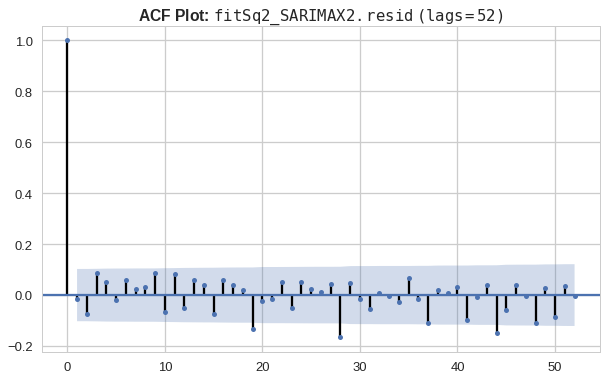

In [42]:
# ACF Plot: fitSq2_SARIMAX2.resid
maxLags=52
sm.graphics.tsa.plot_acf(fitSq2_SARIMAX2.resid, ax=None, lags=maxLags, 
                         unbiased=True, title=r'ACF Plot: $\mathtt{fitSq2\_SARIMAX2.resid\ (lags=52)}$')
plt.show()

From the diagnostic diagrams above, and especially the ones that corresponds to the best of our models, $\mathbf{ARIMA(2,0,0)\,\times\,(1,0,1)_{7}}$ **(`fitSq2_SARIMAX2`)**, we observe that ***outliers exist*** in ***time series***, ***during the hot summer months*** and the ***the last few days of 2014***, but they are not many (Standardized Residuals timeseries plot). The Normal Q-Q plot of Residuals shows ***departure from normality at the
tails*** due to the outliers that occurred primarily during the ***first and last few days of 2014***. Furthermore, the ACF Plot of Residuals reveals some autocorrelation, but it is not significant.

#### C. Model Comparison: `fitSq2INT2_SARIMAX1` vs `fitSq2_SARIMAX2`


'fitSq2INT2_SARIMAX1' model:
--------------------------------
                                 Statespace Model Results                                
Dep. Variable:                               kWh   No. Observations:                  365
Model:             SARIMAX(3, 0, 0)x(1, 0, 1, 7)   Log Likelihood               -2363.214
Date:                           Wed, 15 Mar 2017   AIC                           4748.427
Time:                                   16:59:55   BIC                           4791.326
Sample:                               01-01-2014   HQIC                          4765.476
                                    - 12-31-2014                                         
Covariance Type:                             opg                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept    

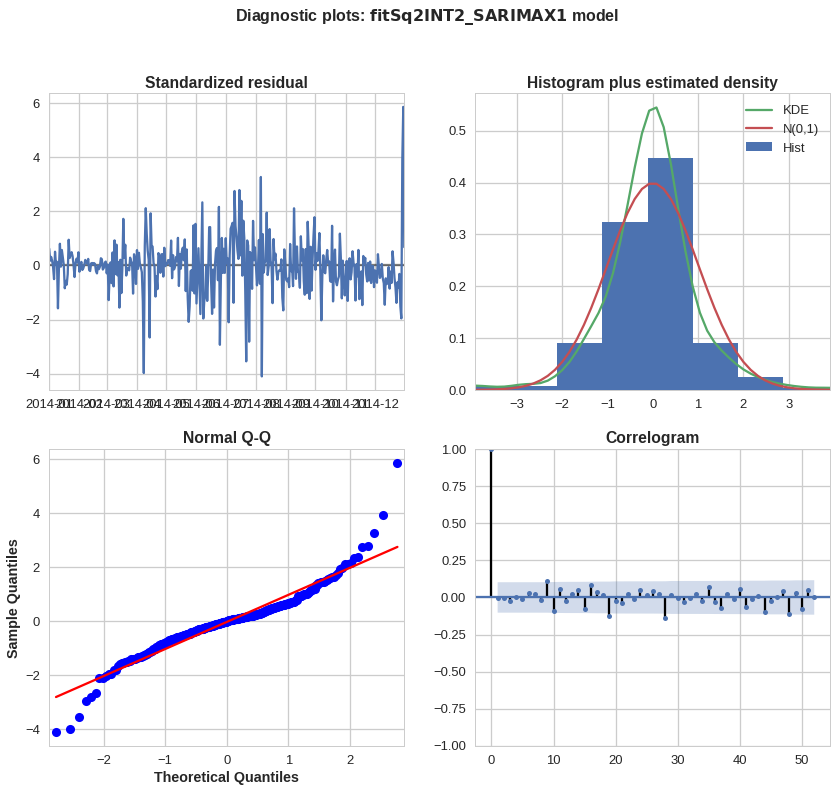


'fitSq2_SARIMAX2' model:
----------------------------
                                 Statespace Model Results                                
Dep. Variable:                               kWh   No. Observations:                  365
Model:             SARIMAX(2, 0, 0)x(1, 0, 1, 7)   Log Likelihood               -2372.967
Date:                           Wed, 15 Mar 2017   AIC                           4763.934
Time:                                   16:59:57   BIC                           4799.033
Sample:                               01-01-2014   HQIC                          4777.883
                                    - 12-31-2014                                         
Covariance Type:                             opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              549.0970     77.465     

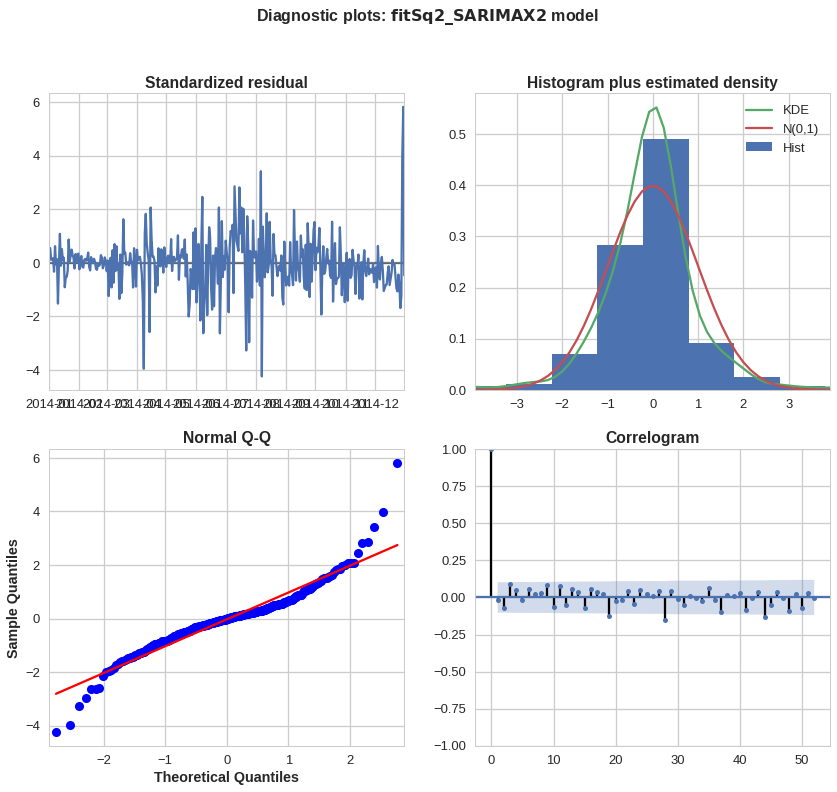

In [43]:
# ARIMA(3,0,0) x (1,0,1)_{7} over "fitSq2INT2"
# Provide the summary of results
s = '\n\'fitSq2INT2_SARIMAX1\' model:'
print(s)
print('-'*(len(s)+3))
print(fitSq2INT2_SARIMAX1.summary())
maxLags = 52
fig = plt.figure(figsize=(14,12))
fitSq2INT2_SARIMAX1.plot_diagnostics(lags=maxLags, fig=fig)
fig.suptitle(r'Diagnostic plots: $\mathbf{fitSq2INT2\_SARIMAX1}$ model',
             fontsize=16, fontweight='bold')
plt.show()

# ARIMA(2,0,0) x (1,0,1)_{7} over "fitSq2"
# Provide the summary of results
s = '\n\'fitSq2_SARIMAX2\' model:'
print(s)
print('-'*(len(s)+3))
print(fitSq2_SARIMAX2.summary())
maxLags = 52
fig = plt.figure(figsize=(14,12))
fitSq2_SARIMAX2.plot_diagnostics(lags=maxLags, fig=fig)
fig.suptitle(r'Diagnostic plots: $\mathbf{fitSq2\_SARIMAX2}$ model',
             fontsize=16, fontweight='bold')
plt.show()

From the **diagnostics diagrams** above and the **Statistics Information Criteria, `AIC`/`BIC`**, we conclude that the **`fitSq2INT2_SARIMAX1`** model is slightly better than the other, simpler one, **`fitSq2_SARIMAX1`**.

In the next section, we are going to use the **`fitSq2INT2_SARIMAX1`** model to provide short and long-term forecasts. The results are indeed great!

## 5. Energy Consumption Forecast (`'kWh'`): comparison with FB `'prophet'` predictions

Finally, we provide an **Energy Consumption Forecast (`'kWh'`)** based on this last model, **`fitSq2INT2_SARIMAX1`**, for the next 60 and 90 calendar days and for a long-term period. Note that our model have great predictive performance both for short and long-term time periods.

In another front, we compare our results with the one returned by the **[FB prophet](https://facebookincubator.github.io/prophet/)** library, as it was trained over the **`'rkWh'`** timeseries alone. We find that this model also provide good results, although shifted towards greater values of forecasted consumed energy than the one had during the same periods in 2014.

### Fit the FB `'prophet'` library over the `"ragg['kWh']"` timeseries

In [44]:
df = pd.DataFrame(data={'ds': ragg.index.values, 'y': ragg['kWh'].values})
m = Prophet()
m.fit(df);

### Short-term Forecast: next 60 & 90 calendar days

Finally, we can do post-estimation prediction and forecasting. Notice that the end period can be specified as a date.

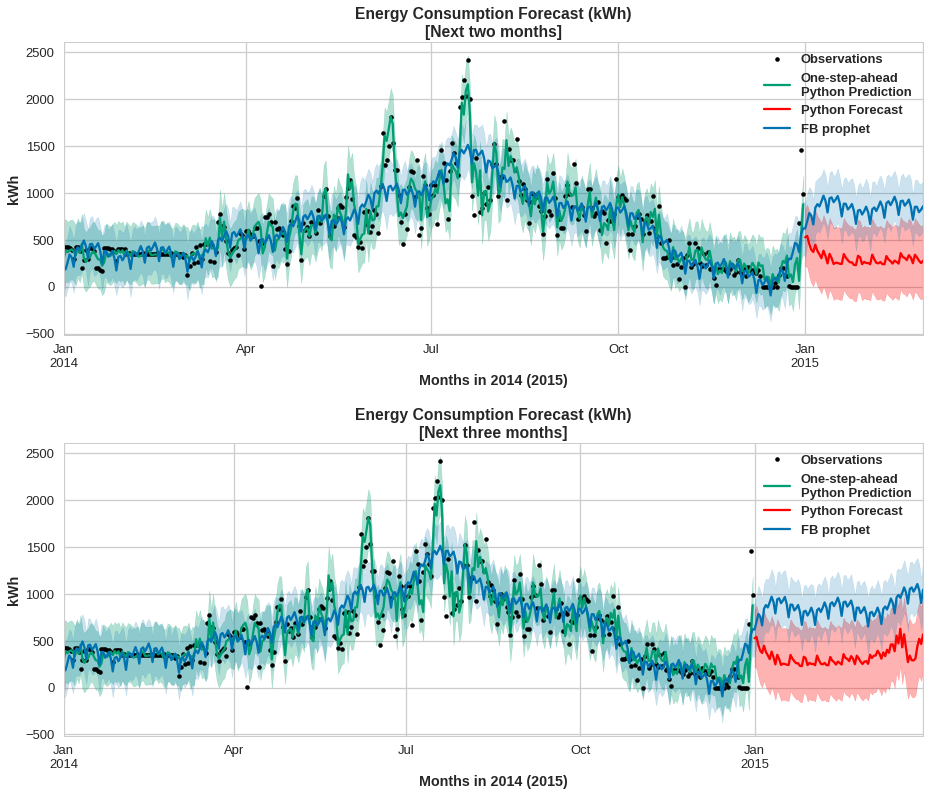

In [45]:
# Design Matrix
XReg = fitSq2INT2.model.data.orig_exog

# Plot the results
fig, (ax1, ax2)= plt.subplots(nrows=2, ncols=1, figsize=(14,12))

# Next Two Months [JAN-FEB (2015)]
nAhead = 31+28
# Perform prediction and forecasting
fitSq2INT2_SARIMAX1_pred = fitSq2INT2_SARIMAX1.get_prediction(start='2014-01-01', end='2014-12-31', exog=XReg)
fitSq2INT2_SARIMAX1_fore = fitSq2INT2_SARIMAX1.get_forecast(steps='2015-02-28', exog=XReg[0:59])
fitSq2INT2_SARIMAX1_predResults = fitSq2INT2_SARIMAX1_pred.summary_frame()
fitSq2INT2_SARIMAX1_foreResults = fitSq2INT2_SARIMAX1_fore.summary_frame()
future = m.make_future_dataframe(nAhead+1, freq='D')
fitSq2INT2_SARIMAX1_foreFB = m.predict(future)
fitSq2INT2_SARIMAX1_foreFB.index = fitSq2INT2_SARIMAX1_foreFB['ds'].values
# One-step-ahead Python prediction
ragg1['kWh'].plot(ax=ax1, style='k.', label='Observations')
fitSq2INT2_SARIMAX1_predResults['mean'].plot(ax=ax1, label='One-step-ahead\nPython Prediction',
                                             ls='-', c='#009E73')
ax1.fill_between(fitSq2INT2_SARIMAX1_predResults.index, 
                 fitSq2INT2_SARIMAX1_predResults['mean_ci_lower'], 
                 fitSq2INT2_SARIMAX1_predResults['mean_ci_upper'], color='#009E73', alpha=0.3)
# two-months Python forecast
fitSq2INT2_SARIMAX1_foreResults['mean'].plot(ax=ax1, label='Python Forecast',
                                             ls='-', c='r')
ax1.fill_between(fitSq2INT2_SARIMAX1_foreResults.index, 
                 fitSq2INT2_SARIMAX1_foreResults['mean_ci_lower'], 
                 fitSq2INT2_SARIMAX1_foreResults['mean_ci_upper'], color='r', alpha=0.3)
# two-months FB prophet forecast
fitSq2INT2_SARIMAX1_foreFB['yhat'].plot(ax=ax1, label='FB prophet',
                                        ls='-', c='#0072B2')
ax1.fill_between(fitSq2INT2_SARIMAX1_foreFB.index, 
                 fitSq2INT2_SARIMAX1_foreFB['yhat_lower'], 
                 fitSq2INT2_SARIMAX1_foreFB['yhat_upper'], color='#0072B2', alpha=0.2)
# Cleanup the image
legend = ax1.legend(loc='upper right', prop={'weight':'bold'});
ax1.set_xlim(('2014-01-01', '2015-02-28'));
ax1.set_xlabel('Months in 2014 (2015)')
ax1.set_ylabel('kWh')
ax1.set_title('Energy Consumption Forecast (kWh)\n[Next two months]')

# Next Three Months [JAN-MAR (2015)]
nAhead = 31+28+31
# Perform prediction and forecasting
fitSq2INT2_SARIMAX1_pred = fitSq2INT2_SARIMAX1.get_prediction(start='2014-01-01', end='2014-12-31', exog=XReg)
fitSq2INT2_SARIMAX1_fore = fitSq2INT2_SARIMAX1.get_forecast(steps='2015-03-31', exog=XReg[0:90])
fitSq2INT2_SARIMAX1_predResults = fitSq2INT2_SARIMAX1_pred.summary_frame()
fitSq2INT2_SARIMAX1_foreResults = fitSq2INT2_SARIMAX1_fore.summary_frame()
future = m.make_future_dataframe(nAhead+1, freq='D')
fitSq2INT2_SARIMAX1_foreFB = m.predict(future)
fitSq2INT2_SARIMAX1_foreFB.index = fitSq2INT2_SARIMAX1_foreFB['ds'].values
# One-step-ahead Python prediction
ragg1['kWh'].plot(ax=ax2, style='k.', label='Observations')
fitSq2INT2_SARIMAX1_predResults['mean'].plot(ax=ax2, label='One-step-ahead\nPython Prediction', 
                                             ls='-', c='#009E73')
ax2.fill_between(fitSq2INT2_SARIMAX1_predResults.index, 
                 fitSq2INT2_SARIMAX1_predResults['mean_ci_lower'], 
                 fitSq2INT2_SARIMAX1_predResults['mean_ci_upper'], color='#009E73', alpha=0.3)
# two-months Python forecast
fitSq2INT2_SARIMAX1_foreResults['mean'].plot(ax=ax2, label='Python Forecast',
                                             ls='-', c='r')
ax2.fill_between(fitSq2INT2_SARIMAX1_foreResults.index, 
                 fitSq2INT2_SARIMAX1_foreResults['mean_ci_lower'], 
                 fitSq2INT2_SARIMAX1_foreResults['mean_ci_upper'], color='red', alpha=0.3)
# two-months FB prophet forecast
fitSq2INT2_SARIMAX1_foreFB['yhat'].plot(ax=ax2, label='FB prophet',
                                        ls='-', c='#0072B2')
ax2.fill_between(fitSq2INT2_SARIMAX1_foreFB.index, 
                 fitSq2INT2_SARIMAX1_foreFB['yhat_lower'], 
                 fitSq2INT2_SARIMAX1_foreFB['yhat_upper'], color='#0072B2', alpha=0.2)
# Cleanup the image
legend = ax2.legend(loc='upper right', prop={'weight':'bold'});
ax2.set_xlim(('2014-01-01', '2015-03-31'));
ax2.set_xlabel('Months in 2014 (2015)')
ax2.set_ylabel('kWh')
ax2.set_title('Energy Consumption Forecast (kWh)\n[Next three months]')

# Figure polishing
plt.tight_layout(h_pad=2, w_pad=2, rect=[0,0,0.93,0.93])

### Long-term Forecast: next semester & next year

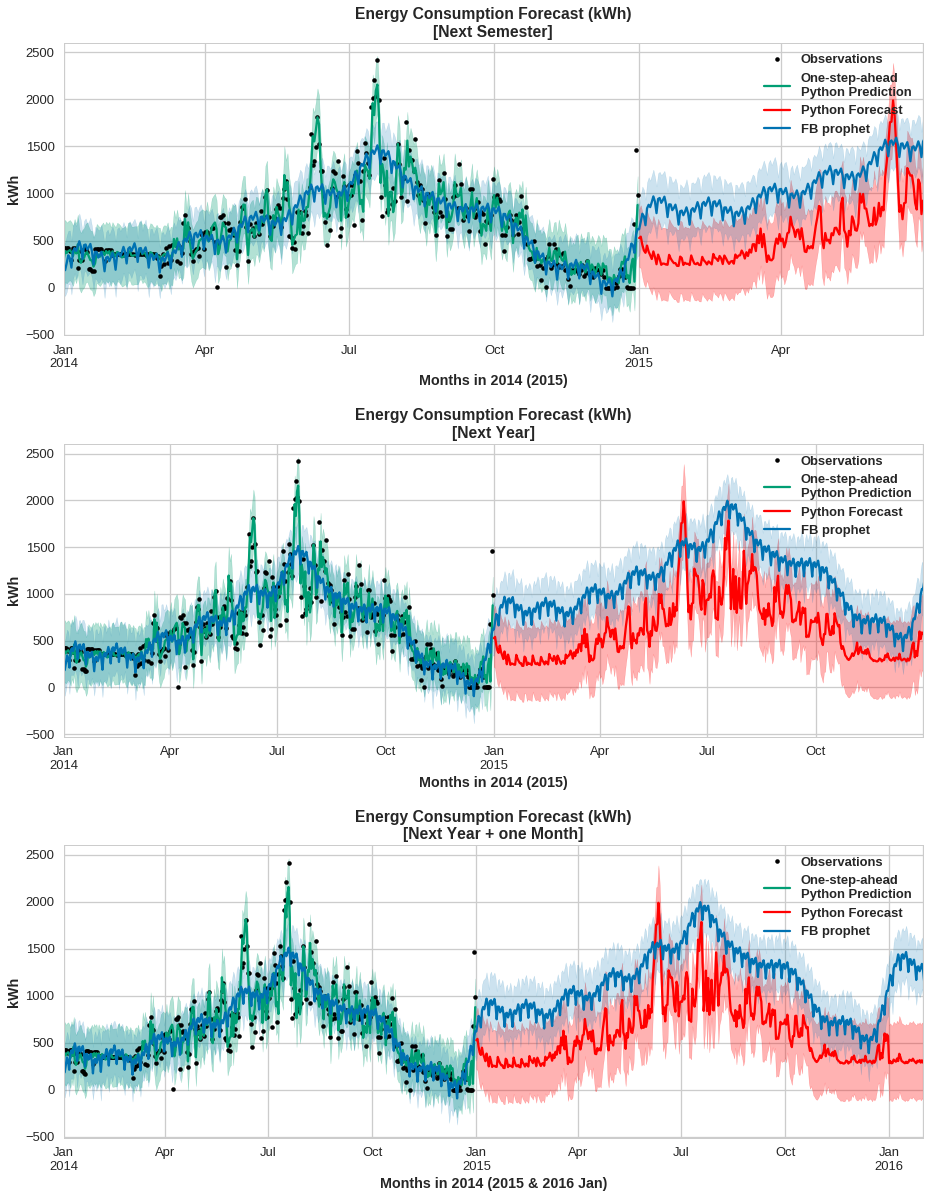

In [46]:
# Design Matrix
XReg = fitSq2INT2.model.data.orig_exog

# Plot the results
fig, (ax1, ax2, ax3)= plt.subplots(nrows=3, ncols=1, figsize=(14,18))

# Next Semester (2015)
nAhead = 31+28+31+30+31+30
# Perform prediction and forecasting
fitSq2INT2_SARIMAX1_pred = fitSq2INT2_SARIMAX1.get_prediction(start='2014-01-01', end='2014-12-31', exog=XReg)
fitSq2INT2_SARIMAX1_fore = fitSq2INT2_SARIMAX1.get_forecast(steps='2015-06-30', exog=XReg[0:181])
fitSq2INT2_SARIMAX1_predResults = fitSq2INT2_SARIMAX1_pred.summary_frame()
fitSq2INT2_SARIMAX1_foreResults = fitSq2INT2_SARIMAX1_fore.summary_frame()
future = m.make_future_dataframe(nAhead+1, freq='D')
fitSq2INT2_SARIMAX1_foreFB = m.predict(future)
fitSq2INT2_SARIMAX1_foreFB.index = fitSq2INT2_SARIMAX1_foreFB['ds'].values
# One-step-ahead Python prediction
ragg1['kWh'].plot(ax=ax1, style='k.', label='Observations')
fitSq2INT2_SARIMAX1_predResults['mean'].plot(ax=ax1, label='One-step-ahead\nPython Prediction',
                                             ls='-', c='#009E73')
ax1.fill_between(fitSq2INT2_SARIMAX1_predResults.index, 
                 fitSq2INT2_SARIMAX1_predResults['mean_ci_lower'], 
                 fitSq2INT2_SARIMAX1_predResults['mean_ci_upper'], color='#009E73', alpha=0.3)
# Next Semester Python forecast
fitSq2INT2_SARIMAX1_foreResults['mean'].plot(ax=ax1, label='Python Forecast',
                                             ls='-', c='r')
ax1.fill_between(fitSq2INT2_SARIMAX1_foreResults.index, 
                 fitSq2INT2_SARIMAX1_foreResults['mean_ci_lower'], 
                 fitSq2INT2_SARIMAX1_foreResults['mean_ci_upper'], color='r', alpha=0.3)
# Next Semester FB prophet forecast
fitSq2INT2_SARIMAX1_foreFB['yhat'].plot(ax=ax1, label='FB prophet',
                                        ls='-', c='#0072B2')
ax1.fill_between(fitSq2INT2_SARIMAX1_foreFB.index, 
                 fitSq2INT2_SARIMAX1_foreFB['yhat_lower'], 
                 fitSq2INT2_SARIMAX1_foreFB['yhat_upper'], color='#0072B2', alpha=0.2)
# Cleanup the image
legend = ax1.legend(loc='upper right', prop={'weight':'bold'});
ax1.set_xlim(('2014-01-01', '2015-06-30'));
ax1.set_xlabel('Months in 2014 (2015)')
ax1.set_ylabel('kWh')
ax1.set_title('Energy Consumption Forecast (kWh)\n[Next Semester]')

# Next Year (2015)
nAhead = 365
# Perform prediction and forecasting
fitSq2INT2_SARIMAX1_pred = fitSq2INT2_SARIMAX1.get_prediction(start='2014-01-01', end='2014-12-31', exog=XReg)
fitSq2INT2_SARIMAX1_fore = fitSq2INT2_SARIMAX1.get_forecast(steps='2015-12-31', exog=XReg)
fitSq2INT2_SARIMAX1_predResults = fitSq2INT2_SARIMAX1_pred.summary_frame()
fitSq2INT2_SARIMAX1_foreResults = fitSq2INT2_SARIMAX1_fore.summary_frame()
future = m.make_future_dataframe(nAhead+1, freq='D')
fitSq2INT2_SARIMAX1_foreFB = m.predict(future)
fitSq2INT2_SARIMAX1_foreFB.index = fitSq2INT2_SARIMAX1_foreFB['ds'].values
# One-step-ahead Python prediction
ragg1['kWh'].plot(ax=ax2, style='k.', label='Observations')
fitSq2INT2_SARIMAX1_predResults['mean'].plot(ax=ax2, label='One-step-ahead\nPython Prediction',
                                             ls='-', c='#009E73')
ax2.fill_between(fitSq2INT2_SARIMAX1_predResults.index, 
                 fitSq2INT2_SARIMAX1_predResults['mean_ci_lower'], 
                 fitSq2INT2_SARIMAX1_predResults['mean_ci_upper'], color='#009E73', alpha=0.3)
# Next Semester Python forecast
fitSq2INT2_SARIMAX1_foreResults['mean'].plot(ax=ax2, label='Python Forecast',
                                             ls='-', c='r')
ax2.fill_between(fitSq2INT2_SARIMAX1_foreResults.index, 
                 fitSq2INT2_SARIMAX1_foreResults['mean_ci_lower'], 
                 fitSq2INT2_SARIMAX1_foreResults['mean_ci_upper'], color='r', alpha=0.3)
# Next Semester FB prophet forecast
fitSq2INT2_SARIMAX1_foreFB['yhat'].plot(ax=ax2, label='FB prophet',
                                        ls='-', c='#0072B2')
ax2.fill_between(fitSq2INT2_SARIMAX1_foreFB.index, 
                 fitSq2INT2_SARIMAX1_foreFB['yhat_lower'], 
                 fitSq2INT2_SARIMAX1_foreFB['yhat_upper'], color='#0072B2', alpha=0.2)
# Cleanup the image
legend = ax2.legend(loc='upper right', prop={'weight':'bold'});
ax2.set_xlim(('2014-01-01', '2015-12-31'));
ax2.set_xlabel('Months in 2014 (2015)')
ax2.set_ylabel('kWh')
ax2.set_title('Energy Consumption Forecast (kWh)\n[Next Year]')

# Next Year + One Month (2015, 2016)
nAhead = 365 + 31
# Perform prediction and forecasting
fitSq2INT2_SARIMAX1_pred = fitSq2INT2_SARIMAX1.get_prediction(start='2014-01-01', end='2014-12-31', exog=XReg)
fitSq2INT2_SARIMAX1_fore = fitSq2INT2_SARIMAX1.get_forecast(steps='2016-01-31', 
                                                            exog=np.row_stack((XReg, XReg[0:31])))
fitSq2INT2_SARIMAX1_predResults = fitSq2INT2_SARIMAX1_pred.summary_frame()
fitSq2INT2_SARIMAX1_foreResults = fitSq2INT2_SARIMAX1_fore.summary_frame()
future = m.make_future_dataframe(nAhead+1, freq='D')
fitSq2INT2_SARIMAX1_foreFB = m.predict(future)
fitSq2INT2_SARIMAX1_foreFB.index = fitSq2INT2_SARIMAX1_foreFB['ds'].values
# One-step-ahead Python prediction
ragg1['kWh'].plot(ax=ax3, style='k.', label='Observations')
fitSq2INT2_SARIMAX1_predResults['mean'].plot(ax=ax3, label='One-step-ahead\nPython Prediction',
                                             ls='-', c='#009E73')
ax3.fill_between(fitSq2INT2_SARIMAX1_predResults.index, 
                 fitSq2INT2_SARIMAX1_predResults['mean_ci_lower'], 
                 fitSq2INT2_SARIMAX1_predResults['mean_ci_upper'], color='#009E73', alpha=0.3)
# Next Semester Python forecast
fitSq2INT2_SARIMAX1_foreResults['mean'].plot(ax=ax3, label='Python Forecast',
                                             ls='-', c='r')
ax3.fill_between(fitSq2INT2_SARIMAX1_foreResults.index, 
                 fitSq2INT2_SARIMAX1_foreResults['mean_ci_lower'], 
                 fitSq2INT2_SARIMAX1_foreResults['mean_ci_upper'], color='r', alpha=0.3)
# Next Semester FB prophet forecast
fitSq2INT2_SARIMAX1_foreFB['yhat'].plot(ax=ax3, label='FB prophet',
                                        ls='-', c='#0072B2')
ax3.fill_between(fitSq2INT2_SARIMAX1_foreFB.index, 
                 fitSq2INT2_SARIMAX1_foreFB['yhat_lower'], 
                 fitSq2INT2_SARIMAX1_foreFB['yhat_upper'], color='#0072B2', alpha=0.2)
# Cleanup the image
legend = ax3.legend(loc='upper right', prop={'weight':'bold'});
ax3.set_xlim(('2014-01-01', '2016-01-31'));
ax3.set_xlabel('Months in 2014 (2015 & 2016 Jan)')
ax3.set_ylabel('kWh')
ax3.set_title('Energy Consumption Forecast (kWh)\n[Next Year + one Month]')

# Figure polishing
plt.tight_layout(h_pad=2, w_pad=2, rect=[0,0,0.93,0.93])

## 6. Conclusion / Remarks

The regression model with autocorrelated errors we fit previously, namely **`fitSq2INT2_SARIMAX1`**, can provide ***accurate short*** and ***long-term forecasts***.

More specifically, the simulated time series of energy consumption which is returned by the model is surprisingly similar with the one provided, except of course some peaks during the hot summer days and the New Year's Eve. At these times the forecasted consumption is significantly lower than the one had during the same periods in 2014. The reason for this deficiency is two-fold. First, the **`'Temp'`** timeseries and its contribution in the energy consumption can be better accomodated by a better initial regression model. Secondly, the energy consumption peaks during the hot summer months and the New Year's Eve, were treated as outliers by our model. Having historical data of two and more years would allow us to better incorporate these seasonalities in our model and hopefully provide even better predictions.

As a final remark, I expect that this kind of timeseries (**`'kWh'`**) and its dependence from quantitative (**`'Temp'`**) or categorical variables (**`'Traffic'`**) can be also studied by utilizing other time domain methods or state-space practices. On the other hand, the results returned by the **FB prophet** library, as it was trained over the **`'rkWh'`** timeseries alone, were also good but shifted towards greater values of forecasted consumed energy than the one had during the same periods in 2014. We believe that having the ability to incorporate the **`'kWh'` ~ `'Temp'` & `'Traffic'`** dependence in this model, would make it much better.